In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd

In [3]:
torch.__version__

'0.4.1'

In [4]:
USE_CUDA = torch.cuda.is_available()
USE_CUDA

True

In [5]:
torch.cuda.set_device(1)

In [6]:
device = torch.device('cuda' if USE_CUDA else 'cpu')
device

device(type='cuda')

In [7]:
import pyro
import pyro.optim as optim
import pyro.distributions as dist

from renyi_elbo import RenyiELBO

/home/golikov/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Data preparation:

In [8]:
batch_size = 256

** Sample points from 1-dim sphere, and then embed it into 100-dim feature-space with random non-linear map: **

In [9]:
manifold_dim = 1

In [10]:
class ToySamplesBatchGenerator():
    def __init__(self, sample_dim, batch_size, batches_per_epoch, noise_amplitude=0.0, num_components=3, kappa=3):
        super(type(self), self).__init__()
        self.sample_dim = sample_dim
        self.batch_size = batch_size
        self.batches_per_epoch = batches_per_epoch
        self.noise_amplitude = noise_amplitude
        self.num_components = num_components
        
        self.kappa = kappa
        
        self.transform = nn.Sequential(nn.Linear(2, sample_dim), nn.ReLU(), nn.Linear(sample_dim, sample_dim))
        
    def generate_latent_batch(self):
        data = []
        for k in range(self.num_components):
            data.append(
                np.random.vonmises(
                    2 * np.pi * k / self.num_components, self.kappa, size=self.batch_size
                )
            )
        data = np.array(data)
        components = np.random.choice(self.num_components, size=self.batch_size)
        batch_flat = data[components, np.arange(self.batch_size)]
        batch = np.stack((np.cos(batch_flat), np.sin(batch_flat)), axis=1)
        return batch, components
    
    def transform_batch(self, batch):
        with torch.no_grad():
            return self.transform(torch.from_numpy(batch).float()).numpy()
    
    def __call__(self):
        def generator():
            for count in range(self.batches_per_epoch):
                latent_batch, components = self.generate_latent_batch()
                batch = self.transform_batch(latent_batch)
                batch += np.random.normal(size=(self.batch_size, self.sample_dim)) * self.noise_amplitude
                yield torch.from_numpy(batch).float(), components
        return generator

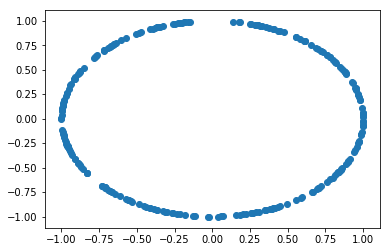

In [11]:
input_dim = 100

toy_samples_batch_gen = ToySamplesBatchGenerator(
    input_dim, batch_size, 1000, noise_amplitude=0.0, num_components=1, kappa=0
)

latent_batch, components = toy_samples_batch_gen.generate_latent_batch()

for k in range(toy_samples_batch_gen.num_components):
    plt.scatter(*np.split(latent_batch[components==k], 2, axis=1))

** We track losses (minus elbos) and (optionally) loglikelihoods (computed with IWELBO approach): **

In [56]:
num_runs = 10

num_iwelbo_samples = 500
track_loglikelihoods = False

loglikelihoods = {}
losses = {}

model_names = []

## Beta-Gauss VAE, 2d:

In [57]:
class ReshapeLayer(nn.Module):
    def __init__(self, *args):
        super(ReshapeLayer, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(x.shape[0], *self.shape)

In [58]:
class EncoderFC(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim=50):
        super(type(self), self).__init__()
        self.body = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            #nn.Linear(hidden_dim, hidden_dim),
            #nn.LeakyReLU(0.2),
        )
        self.head1 = nn.Linear(hidden_dim, latent_dim)
        self.head2 = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, X):
        Z = self.body(X)
        return torch.exp(self.head1(Z)), torch.exp(self.head2(Z))

In [59]:
class DecoderFC(nn.Module):
    def __init__(self, latent_dim, input_dim, hidden_dim=50):
        super(type(self), self).__init__()
        self.body = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            #nn.Linear(hidden_dim, hidden_dim),
            #nn.LeakyReLU(0.2),
        )
        self.mu_head = nn.Linear(hidden_dim, input_dim)
        self.log_sigma_head = nn.Linear(hidden_dim, input_dim)
        
    def forward(self, X):
        Z = self.body(X)
        return self.mu_head(Z), torch.exp(self.log_sigma_head(Z))

In [60]:
import warnings

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(type(self), self).__init__()

        self.latent_dim = latent_dim
        
        self.encoder = EncoderFC(input_dim, latent_dim)
        self.decoder = DecoderFC(latent_dim, input_dim)
        
    def model(self, X):
        pyro.module('decoder', self.decoder)
        with pyro.iarange('data', X.shape[0]):
            Z_base_1 = X.new_ones((X.shape[0], self.latent_dim))
            Z_base_2 = X.new_ones((X.shape[0], self.latent_dim))
            
            base_dist = dist.Beta(Z_base_1, Z_base_2).independent(1)
            Z = pyro.sample('latent', base_dist)
            
            X_obs_mean, X_obs_std = self.decoder(Z)
            pyro.sample(
                'observation', dist.Normal(X_obs_mean, X_obs_std).independent(1), obs=X
            )
        
    def guide(self, X):
        pyro.module('encoder', self.encoder)
        with pyro.iarange('data', X.shape[0]):
            Z_base_1, Z_base_2 = self.encoder(X)
            
            base_dist = dist.Beta(Z_base_1, Z_base_2).independent(1)
            Z = pyro.sample('latent', base_dist)
        
    def get_loglikelihood_and_kl(self, trace_elbo, X):
        loglikelihood, kl = 0., 0.
        # grab a trace from the generator
        for model_trace, guide_trace in trace_elbo._get_traces(self.model, self.guide, X):
            loglikelihood = loglikelihood + model_trace.nodes['observation']['log_prob_sum']
            kl = kl + guide_trace.nodes['latent']['log_prob_sum'] - model_trace.nodes['latent']['log_prob_sum']

        loglikelihood = loglikelihood / trace_elbo.num_particles
        kl = kl / trace_elbo.num_particles

        if pyro.util.torch_isnan(loglikelihood):
            warnings.warn('Encountered NAN loglikelihood')
        if pyro.util.torch_isnan(kl):
            warnings.warn('Encountered NAN kl')
        return loglikelihood, kl

### Training:

In [61]:
model_name = 'beta-gauss_vae_2d'

losses[model_name] = []
loglikelihoods[model_name] = []

for run in range(num_runs):
    print('run', run+1)

    losses[model_name].append([])

    np.random.seed(run)
    pyro.set_rng_seed(run)

    pyro.clear_param_store()

    vae = VAE(input_dim, manifold_dim+1).to(device)

    optimizer = optim.Adam({'lr': 3e-4, 'betas': (0.9, 0.999)})

    trace_elbo = pyro.infer.Trace_ELBO()
    svi = pyro.infer.SVI(vae.model, vae.guide, optimizer, loss=trace_elbo)

    num_epochs = 200

    for epoch in range(num_epochs):
        print('epoch =', epoch+1)

        cum_train_loss = 0
        train_size = 0
        for X, _ in toy_samples_batch_gen()():
            X = X.to(device)
            cum_train_loss += svi.step(X)
            train_size += X.shape[0]
        mean_train_loss = cum_train_loss / train_size
        print('train_loss: {:.4f}'.format(mean_train_loss))

        losses[model_name][run].append(mean_train_loss)

    if track_loglikelihoods:
        iwelbo = RenyiELBO(alpha=0, num_particles=num_iwelbo_samples)

        cum_train_loglikelihood = 0
        train_size = 0
        for X in toy_samples_batch_gen()():
            X = X[0].to(device)
            cum_train_loglikelihood -= iwelbo.loss(vae.model, vae.guide, X)
            train_size += X.shape[0]
        mean_train_loglikelihood = cum_train_loglikelihood / train_size
        print('train_loglikelihood: {:.4f}'.format(mean_train_loglikelihood))

        loglikelihoods[model_name].append(mean_train_loglikelihood)
    
    torch.save(vae.state_dict(), '{}_run={}.pt'.format(model_name, run+1))
    print()


run 1
epoch = 1
train_loss: -117.4179
epoch = 2
train_loss: -219.5644
epoch = 3
train_loss: -255.2204
epoch = 4
train_loss: -278.9339
epoch = 5
train_loss: -286.5694
epoch = 6
train_loss: -290.9603
epoch = 7
train_loss: -293.6149
epoch = 8
train_loss: -295.4496
epoch = 9
train_loss: -296.8726
epoch = 10
train_loss: -298.0921
epoch = 11
train_loss: -299.2036
epoch = 12
train_loss: -300.4557
epoch = 13
train_loss: -301.4017
epoch = 14
train_loss: -302.1177
epoch = 15
train_loss: -302.4969
epoch = 16
train_loss: -302.9222
epoch = 17
train_loss: -303.3127
epoch = 18
train_loss: -303.7148
epoch = 19
train_loss: -304.0293
epoch = 20
train_loss: -304.4140
epoch = 21
train_loss: -304.6805
epoch = 22
train_loss: -305.0402
epoch = 23
train_loss: -305.3061
epoch = 24
train_loss: -305.5666
epoch = 25
train_loss: -305.8155
epoch = 26
train_loss: -306.0532
epoch = 27
train_loss: -306.2389
epoch = 28
train_loss: -306.5533
epoch = 29
train_loss: -306.7343
epoch = 30
train_loss: -306.9543
epoch = 31
tr

train_loss: -299.8184
epoch = 48
train_loss: -299.9326
epoch = 49
train_loss: -299.9250
epoch = 50
train_loss: -300.0448
epoch = 51
train_loss: -300.0748
epoch = 52
train_loss: -300.1138
epoch = 53
train_loss: -300.1803
epoch = 54
train_loss: -300.2811
epoch = 55
train_loss: -300.3738
epoch = 56
train_loss: -300.3828
epoch = 57
train_loss: -300.4894
epoch = 58
train_loss: -300.4840
epoch = 59
train_loss: -300.5958
epoch = 60
train_loss: -300.5916
epoch = 61
train_loss: -300.8351
epoch = 62
train_loss: -301.3830
epoch = 63
train_loss: -302.4432
epoch = 64
train_loss: -303.3992
epoch = 65
train_loss: -304.4636
epoch = 66
train_loss: -305.5843
epoch = 67
train_loss: -306.4019
epoch = 68
train_loss: -307.1062
epoch = 69
train_loss: -307.8507
epoch = 70
train_loss: -308.4102
epoch = 71
train_loss: -308.9615
epoch = 72
train_loss: -309.4524
epoch = 73
train_loss: -309.9295
epoch = 74
train_loss: -310.2702
epoch = 75
train_loss: -310.6971
epoch = 76
train_loss: -311.0121
epoch = 77
train_loss

train_loss: -337.0462
epoch = 94
train_loss: -337.3397
epoch = 95
train_loss: -337.7289
epoch = 96
train_loss: -338.2101
epoch = 97
train_loss: -338.5446
epoch = 98
train_loss: -338.9205
epoch = 99
train_loss: -339.3608
epoch = 100
train_loss: -339.7097
epoch = 101
train_loss: -340.0503
epoch = 102
train_loss: -340.4304
epoch = 103
train_loss: -340.7961
epoch = 104
train_loss: -341.1773
epoch = 105
train_loss: -341.4860
epoch = 106
train_loss: -341.8945
epoch = 107
train_loss: -342.2171
epoch = 108
train_loss: -342.5355
epoch = 109
train_loss: -342.8391
epoch = 110
train_loss: -343.1475
epoch = 111
train_loss: -343.5638
epoch = 112
train_loss: -343.8701
epoch = 113
train_loss: -344.1428
epoch = 114
train_loss: -344.4373
epoch = 115
train_loss: -344.7564
epoch = 116
train_loss: -345.0792
epoch = 117
train_loss: -345.2148
epoch = 118
train_loss: -345.4635
epoch = 119
train_loss: -345.7741
epoch = 120
train_loss: -346.0026
epoch = 121
train_loss: -346.1917
epoch = 122
train_loss: -346.303

train_loss: -331.4821
epoch = 139
train_loss: -331.4820
epoch = 140
train_loss: -331.5469
epoch = 141
train_loss: -331.5968
epoch = 142
train_loss: -331.7268
epoch = 143
train_loss: -332.1243
epoch = 144
train_loss: -333.5947
epoch = 145
train_loss: -335.4927
epoch = 146
train_loss: -337.3055
epoch = 147
train_loss: -338.7555
epoch = 148
train_loss: -339.6771
epoch = 149
train_loss: -340.6396
epoch = 150
train_loss: -341.3208
epoch = 151
train_loss: -341.8122
epoch = 152
train_loss: -342.5829
epoch = 153
train_loss: -343.1094
epoch = 154
train_loss: -343.4615
epoch = 155
train_loss: -344.0090
epoch = 156
train_loss: -344.3577
epoch = 157
train_loss: -344.7951
epoch = 158
train_loss: -345.2636
epoch = 159
train_loss: -345.6948
epoch = 160
train_loss: -346.0100
epoch = 161
train_loss: -346.5019
epoch = 162
train_loss: -346.8388
epoch = 163
train_loss: -347.2679
epoch = 164
train_loss: -347.5057
epoch = 165
train_loss: -347.9086
epoch = 166
train_loss: -348.1436
epoch = 167
train_loss: -3

train_loss: -339.3188
epoch = 183
train_loss: -339.4630
epoch = 184
train_loss: -339.6435
epoch = 185
train_loss: -339.8317
epoch = 186
train_loss: -339.9800
epoch = 187
train_loss: -340.1263
epoch = 188
train_loss: -340.2829
epoch = 189
train_loss: -340.4030
epoch = 190
train_loss: -340.5642
epoch = 191
train_loss: -340.6690
epoch = 192
train_loss: -340.8445
epoch = 193
train_loss: -341.0146
epoch = 194
train_loss: -341.1903
epoch = 195
train_loss: -341.3184
epoch = 196
train_loss: -341.4225
epoch = 197
train_loss: -341.5451
epoch = 198
train_loss: -341.6615
epoch = 199
train_loss: -341.8424
epoch = 200
train_loss: -342.0768

run 6
epoch = 1
train_loss: -121.5633
epoch = 2
train_loss: -236.6429
epoch = 3
train_loss: -255.9458
epoch = 4
train_loss: -262.9948
epoch = 5
train_loss: -266.2629
epoch = 6
train_loss: -268.1393
epoch = 7
train_loss: -269.2831
epoch = 8
train_loss: -270.0805
epoch = 9
train_loss: -270.8557
epoch = 10
train_loss: -272.1512
epoch = 11
train_loss: -275.3420
epoch

train_loss: -310.9048
epoch = 28
train_loss: -312.1065
epoch = 29
train_loss: -313.0808
epoch = 30
train_loss: -314.1982
epoch = 31
train_loss: -314.9547
epoch = 32
train_loss: -315.9027
epoch = 33
train_loss: -316.7937
epoch = 34
train_loss: -317.8696
epoch = 35
train_loss: -318.9196
epoch = 36
train_loss: -319.8460
epoch = 37
train_loss: -320.4942
epoch = 38
train_loss: -321.1842
epoch = 39
train_loss: -321.6981
epoch = 40
train_loss: -322.2929
epoch = 41
train_loss: -322.6936
epoch = 42
train_loss: -323.2132
epoch = 43
train_loss: -323.5651
epoch = 44
train_loss: -324.0165
epoch = 45
train_loss: -324.4306
epoch = 46
train_loss: -324.6514
epoch = 47
train_loss: -325.1413
epoch = 48
train_loss: -325.5129
epoch = 49
train_loss: -326.0303
epoch = 50
train_loss: -326.2697
epoch = 51
train_loss: -326.7114
epoch = 52
train_loss: -326.9819
epoch = 53
train_loss: -327.3916
epoch = 54
train_loss: -327.7436
epoch = 55
train_loss: -328.1289
epoch = 56
train_loss: -328.4393
epoch = 57
train_loss

train_loss: -354.3671
epoch = 74
train_loss: -354.9690
epoch = 75
train_loss: -355.3844
epoch = 76
train_loss: -355.7903
epoch = 77
train_loss: -356.3858
epoch = 78
train_loss: -356.6582
epoch = 79
train_loss: -357.1343
epoch = 80
train_loss: -357.6316
epoch = 81
train_loss: -357.9617
epoch = 82
train_loss: -358.4550
epoch = 83
train_loss: -358.8020
epoch = 84
train_loss: -359.1321
epoch = 85
train_loss: -359.4555
epoch = 86
train_loss: -359.9063
epoch = 87
train_loss: -360.1960
epoch = 88
train_loss: -360.6191
epoch = 89
train_loss: -360.8706
epoch = 90
train_loss: -361.3669
epoch = 91
train_loss: -361.6224
epoch = 92
train_loss: -361.9130
epoch = 93
train_loss: -362.2647
epoch = 94
train_loss: -362.5164
epoch = 95
train_loss: -362.8393
epoch = 96
train_loss: -363.2132
epoch = 97
train_loss: -363.4348
epoch = 98
train_loss: -363.7510
epoch = 99
train_loss: -364.1437
epoch = 100
train_loss: -364.4259
epoch = 101
train_loss: -364.6657
epoch = 102
train_loss: -364.9799
epoch = 103
train_

train_loss: -382.6395
epoch = 119
train_loss: -383.0179
epoch = 120
train_loss: -383.0507
epoch = 121
train_loss: -383.3140
epoch = 122
train_loss: -383.5518
epoch = 123
train_loss: -383.7790
epoch = 124
train_loss: -383.8269
epoch = 125
train_loss: -383.9808
epoch = 126
train_loss: -384.2271
epoch = 127
train_loss: -384.1625
epoch = 128
train_loss: -384.5105
epoch = 129
train_loss: -384.8363
epoch = 130
train_loss: -384.8841
epoch = 131
train_loss: -385.0037
epoch = 132
train_loss: -385.1200
epoch = 133
train_loss: -385.2672
epoch = 134
train_loss: -385.3414
epoch = 135
train_loss: -385.6985
epoch = 136
train_loss: -385.6737
epoch = 137
train_loss: -385.9409
epoch = 138
train_loss: -385.8997
epoch = 139
train_loss: -386.0132
epoch = 140
train_loss: -386.2687
epoch = 141
train_loss: -386.3769
epoch = 142
train_loss: -386.3112
epoch = 143
train_loss: -386.6671
epoch = 144
train_loss: -387.0243
epoch = 145
train_loss: -386.9751
epoch = 146
train_loss: -387.1711
epoch = 147
train_loss: -3

train_loss: -311.3163
epoch = 163
train_loss: -312.1934
epoch = 164
train_loss: -313.0519
epoch = 165
train_loss: -313.6643
epoch = 166
train_loss: -314.4123
epoch = 167
train_loss: -315.4628
epoch = 168
train_loss: -317.2164
epoch = 169
train_loss: -318.7811
epoch = 170
train_loss: -320.0584
epoch = 171
train_loss: -321.2666
epoch = 172
train_loss: -322.1275
epoch = 173
train_loss: -323.1701
epoch = 174
train_loss: -323.9387
epoch = 175
train_loss: -324.6747
epoch = 176
train_loss: -325.4105
epoch = 177
train_loss: -325.9759
epoch = 178
train_loss: -326.5643
epoch = 179
train_loss: -327.1429
epoch = 180
train_loss: -327.8639
epoch = 181
train_loss: -328.3568
epoch = 182
train_loss: -328.9751
epoch = 183
train_loss: -329.7320
epoch = 184
train_loss: -330.0022
epoch = 185
train_loss: -330.9341
epoch = 186
train_loss: -331.7144
epoch = 187
train_loss: -332.3181
epoch = 188
train_loss: -332.9954
epoch = 189
train_loss: -333.2756
epoch = 190
train_loss: -333.5577
epoch = 191
train_loss: -3

### Results:

In [62]:
model_names.append(model_name)

Text(0.5,0,'epoch')

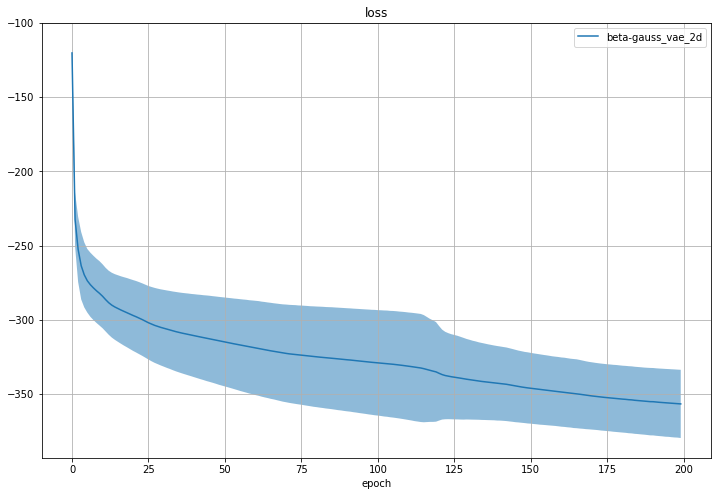

In [63]:
plt.figure(figsize=(12, 8))

for model_name in model_names:
    mean = np.mean(losses[model_name], axis=0)
    std = np.std(losses[model_name], axis=0)
    plt.plot(mean)
    plt.fill_between(
        np.arange(num_epochs), mean - std, mean + std, alpha=0.5
    )
plt.legend(model_names)
plt.grid(True)
plt.title('loss')
plt.xlabel('epoch')

In [64]:
for model_name in model_names:
    print('{}:'.format(model_name))
    mean = np.mean(losses[model_name], axis=0)[-1]
    std = np.std(losses[model_name], axis=0)[-1]
    print('test elbo: {:.4f}+-{:.4f}'.format(-mean, std))
    if track_loglikelihoods:
        mean = np.mean(loglikelihoods[model_name])
        std = np.std(loglikelihoods[model_name])
        print('test loglikelihood: {:.4f}+-{:.4f}'.format(mean, std))

beta-gauss_vae_2d:
test elbo: 356.5336+-22.9595


** Visualize data embedded into latent space: **

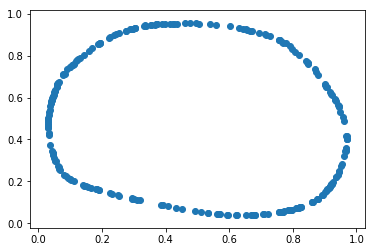

In [65]:
with torch.no_grad():
    X, components = next(iter(toy_samples_batch_gen()()))
    X = X.to(device)

    Z_1, Z_2 = vae.encoder(X)
    Z = dist.Beta(Z_1, Z_2).sample()
    #Z = Z_mean

    for k in range(toy_samples_batch_gen.num_components):
        plt.scatter(*np.split(Z.cpu().numpy()[components == k], 2, axis=1))

## Beta-Gauss VAE, 1d:

In [66]:
import warnings

class VAE_1D(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(type(self), self).__init__()

        self.latent_dim = latent_dim
        
        self.encoder = EncoderFC(input_dim, latent_dim)
        self.decoder_tail = nn.Sequential(nn.Linear(latent_dim, 50), nn.ReLU(), nn.Linear(50, latent_dim+1))
        self.decoder_head = DecoderFC(latent_dim+1, input_dim)
        self.decoder = nn.Sequential(self.decoder_tail, self.decoder_head)
        
    def model(self, X):
        pyro.module('decoder', self.decoder)
        with pyro.iarange('data', X.shape[0]):
            Z_base_1 = X.new_ones((X.shape[0], self.latent_dim))
            Z_base_2 = X.new_ones((X.shape[0], self.latent_dim))
            
            base_dist = dist.Beta(Z_base_1, Z_base_2).independent(1)
            Z = pyro.sample('latent', base_dist)
            
            X_obs_mean, X_obs_std = self.decoder(Z)
            pyro.sample(
                'observation', dist.Normal(X_obs_mean, X_obs_std).independent(1), obs=X
            )
        
    def guide(self, X):
        pyro.module('encoder', self.encoder)
        with pyro.iarange('data', X.shape[0]):
            Z_base_1, Z_base_2 = self.encoder(X)
            
            base_dist = dist.Beta(Z_base_1, Z_base_2).independent(1)
            Z = pyro.sample('latent', base_dist)
        
    def get_loglikelihood_and_kl(self, trace_elbo, X):
        loglikelihood, kl = 0., 0.
        # grab a trace from the generator
        for model_trace, guide_trace in trace_elbo._get_traces(self.model, self.guide, X):
            loglikelihood = loglikelihood + model_trace.nodes['observation']['log_prob_sum']
            kl = kl + guide_trace.nodes['latent']['log_prob_sum'] - model_trace.nodes['latent']['log_prob_sum']

        loglikelihood = loglikelihood / trace_elbo.num_particles
        kl = kl / trace_elbo.num_particles

        if pyro.util.torch_isnan(loglikelihood):
            warnings.warn('Encountered NAN loglikelihood')
        if pyro.util.torch_isnan(kl):
            warnings.warn('Encountered NAN kl')
        return loglikelihood, kl

In [67]:
model_name = 'beta-gauss_vae_1d'
    
losses[model_name] = []
loglikelihoods[model_name] = []

for run in range(num_runs):
    print('run', run+1)

    losses[model_name].append([])

    np.random.seed(run)
    pyro.set_rng_seed(run)

    pyro.clear_param_store()

    vae = VAE_1D(input_dim, manifold_dim).to(device)

    optimizer = optim.Adam({'lr': 3e-4, 'betas': (0.9, 0.999)})

    trace_elbo = pyro.infer.Trace_ELBO()
    svi = pyro.infer.SVI(vae.model, vae.guide, optimizer, loss=trace_elbo)

    num_epochs = 200

    for epoch in range(num_epochs):
        print('epoch =', epoch+1)

        cum_train_loss = 0
        train_size = 0
        for X, _ in toy_samples_batch_gen()():
            X = X.to(device)
            cum_train_loss += svi.step(X)
            train_size += X.shape[0]
        mean_train_loss = cum_train_loss / train_size
        print('train_loss: {:.4f}'.format(mean_train_loss))

        losses[model_name][run].append(mean_train_loss)

    if track_loglikelihoods:
        iwelbo = RenyiELBO(alpha=0, num_particles=num_iwelbo_samples)

        cum_train_loglikelihood = 0
        train_size = 0
        for X in toy_samples_batch_gen()():
            X = X[0].to(device)
            cum_train_loglikelihood -= iwelbo.loss(vae.model, vae.guide, X)
            train_size += X.shape[0]
        mean_train_loglikelihood = cum_train_loglikelihood / train_size
        print('train_loglikelihood: {:.4f}'.format(mean_train_loglikelihood))

        loglikelihoods[model_name].append(mean_train_loglikelihood)
    
    torch.save(vae.state_dict(), '{}_run={}.pt'.format(model_name, run+1))
    print()


run 1
epoch = 1
train_loss: -74.8539
epoch = 2
train_loss: -132.5411
epoch = 3
train_loss: -145.4168
epoch = 4
train_loss: -152.6580
epoch = 5
train_loss: -156.5042
epoch = 6
train_loss: -158.1681
epoch = 7
train_loss: -158.9333
epoch = 8
train_loss: -160.2604
epoch = 9
train_loss: -161.0642
epoch = 10
train_loss: -161.9118
epoch = 11
train_loss: -162.4975
epoch = 12
train_loss: -163.0547
epoch = 13
train_loss: -164.0185
epoch = 14
train_loss: -164.1692
epoch = 15
train_loss: -164.6203
epoch = 16
train_loss: -165.0166
epoch = 17
train_loss: -165.2535
epoch = 18
train_loss: -165.6614
epoch = 19
train_loss: -165.7483
epoch = 20
train_loss: -165.9422
epoch = 21
train_loss: -166.4101
epoch = 22
train_loss: -166.6765
epoch = 23
train_loss: -166.6713
epoch = 24
train_loss: -167.1938
epoch = 25
train_loss: -167.0281
epoch = 26
train_loss: -167.2435
epoch = 27
train_loss: -167.6237
epoch = 28
train_loss: -167.8882
epoch = 29
train_loss: -167.6618
epoch = 30
train_loss: -168.0465
epoch = 31
tra

train_loss: -167.0206
epoch = 48
train_loss: -167.4497
epoch = 49
train_loss: -167.0294
epoch = 50
train_loss: -167.2306
epoch = 51
train_loss: -167.5063
epoch = 52
train_loss: -167.5260
epoch = 53
train_loss: -167.6620
epoch = 54
train_loss: -167.6501
epoch = 55
train_loss: -167.5830
epoch = 56
train_loss: -167.6091
epoch = 57
train_loss: -167.4605
epoch = 58
train_loss: -167.9291
epoch = 59
train_loss: -168.1569
epoch = 60
train_loss: -168.0330
epoch = 61
train_loss: -167.9914
epoch = 62
train_loss: -167.8817
epoch = 63
train_loss: -168.1941
epoch = 64
train_loss: -168.2190
epoch = 65
train_loss: -167.9582
epoch = 66
train_loss: -168.0631
epoch = 67
train_loss: -168.4840
epoch = 68
train_loss: -168.5079
epoch = 69
train_loss: -168.2729
epoch = 70
train_loss: -168.6447
epoch = 71
train_loss: -168.3132
epoch = 72
train_loss: -168.6944
epoch = 73
train_loss: -168.7561
epoch = 74
train_loss: -168.8944
epoch = 75
train_loss: -168.8562
epoch = 76
train_loss: -169.1657
epoch = 77
train_loss

train_loss: -165.9986
epoch = 94
train_loss: -165.8958
epoch = 95
train_loss: -167.4403
epoch = 96
train_loss: -166.8614
epoch = 97
train_loss: -168.0432
epoch = 98
train_loss: -167.2535
epoch = 99
train_loss: -155.9344
epoch = 100
train_loss: -156.7557
epoch = 101
train_loss: -157.1153
epoch = 102
train_loss: -157.5361
epoch = 103
train_loss: -157.7972
epoch = 104
train_loss: -158.4514
epoch = 105
train_loss: -158.6317
epoch = 106
train_loss: -158.8620
epoch = 107
train_loss: -159.1927
epoch = 108
train_loss: -159.6114
epoch = 109
train_loss: -160.0260
epoch = 110
train_loss: -159.8592
epoch = 111
train_loss: -160.2301
epoch = 112
train_loss: -160.1377
epoch = 113
train_loss: -160.6037
epoch = 114
train_loss: -160.7869
epoch = 115
train_loss: -160.6232
epoch = 116
train_loss: -160.7752
epoch = 117
train_loss: -160.6132
epoch = 118
train_loss: -160.9035
epoch = 119
train_loss: -160.6977
epoch = 120
train_loss: -161.6164
epoch = 121
train_loss: -161.3318
epoch = 122
train_loss: -161.754

train_loss: -167.0240
epoch = 139
train_loss: -167.2454
epoch = 140
train_loss: -167.2758
epoch = 141
train_loss: -167.5157
epoch = 142
train_loss: -167.7047
epoch = 143
train_loss: -168.0078
epoch = 144
train_loss: -167.8927
epoch = 145
train_loss: -168.0805
epoch = 146
train_loss: -167.8782
epoch = 147
train_loss: -168.0949
epoch = 148
train_loss: -168.6448
epoch = 149
train_loss: -168.5533
epoch = 150
train_loss: -168.6746
epoch = 151
train_loss: -168.7211
epoch = 152
train_loss: -168.8840
epoch = 153
train_loss: -169.1278
epoch = 154
train_loss: -168.8450
epoch = 155
train_loss: -169.1750
epoch = 156
train_loss: -169.7160
epoch = 157
train_loss: -169.6086
epoch = 158
train_loss: -169.5533
epoch = 159
train_loss: -169.5658
epoch = 160
train_loss: -169.2054
epoch = 161
train_loss: -170.1203
epoch = 162
train_loss: -170.2555
epoch = 163
train_loss: -170.3974
epoch = 164
train_loss: -170.3234
epoch = 165
train_loss: -170.5053
epoch = 166
train_loss: -170.4256
epoch = 167
train_loss: -1

train_loss: -181.0496
epoch = 183
train_loss: -182.0777
epoch = 184
train_loss: -183.3742
epoch = 185
train_loss: -183.5160
epoch = 186
train_loss: -184.1397
epoch = 187
train_loss: -185.1232
epoch = 188
train_loss: -184.9546
epoch = 189
train_loss: -186.1163
epoch = 190
train_loss: -186.7595
epoch = 191
train_loss: -186.6646
epoch = 192
train_loss: -187.4731
epoch = 193
train_loss: -188.3090
epoch = 194
train_loss: -188.3584
epoch = 195
train_loss: -188.4012
epoch = 196
train_loss: -189.5793
epoch = 197
train_loss: -190.2895
epoch = 198
train_loss: -190.7216
epoch = 199
train_loss: -190.7910
epoch = 200
train_loss: -192.0929

run 6
epoch = 1
train_loss: -76.2499
epoch = 2
train_loss: -125.7151
epoch = 3
train_loss: -133.4067
epoch = 4
train_loss: -139.2000
epoch = 5
train_loss: -142.9331
epoch = 6
train_loss: -145.5055
epoch = 7
train_loss: -146.6991
epoch = 8
train_loss: -147.6044
epoch = 9
train_loss: -148.2484
epoch = 10
train_loss: -148.6140
epoch = 11
train_loss: -149.1889
epoch 

train_loss: -166.5086
epoch = 28
train_loss: -166.9866
epoch = 29
train_loss: -167.0695
epoch = 30
train_loss: -167.3200
epoch = 31
train_loss: -167.2879
epoch = 32
train_loss: -167.3192
epoch = 33
train_loss: -167.6444
epoch = 34
train_loss: -167.9113
epoch = 35
train_loss: -167.9858
epoch = 36
train_loss: -168.1040
epoch = 37
train_loss: -168.3706
epoch = 38
train_loss: -168.6856
epoch = 39
train_loss: -169.0365
epoch = 40
train_loss: -169.2073
epoch = 41
train_loss: -169.4426
epoch = 42
train_loss: -170.2270
epoch = 43
train_loss: -170.0198
epoch = 44
train_loss: -170.4106
epoch = 45
train_loss: -170.7550
epoch = 46
train_loss: -170.8007
epoch = 47
train_loss: -170.7910
epoch = 48
train_loss: -171.1670
epoch = 49
train_loss: -171.2525
epoch = 50
train_loss: -171.6069
epoch = 51
train_loss: -171.5466
epoch = 52
train_loss: -171.9457
epoch = 53
train_loss: -171.8793
epoch = 54
train_loss: -172.1398
epoch = 55
train_loss: -172.3107
epoch = 56
train_loss: -172.1658
epoch = 57
train_loss

train_loss: -179.6737
epoch = 74
train_loss: -179.7973
epoch = 75
train_loss: -179.9536
epoch = 76
train_loss: -180.3438
epoch = 77
train_loss: -180.2046
epoch = 78
train_loss: -180.3389
epoch = 79
train_loss: -180.5775
epoch = 80
train_loss: -180.6188
epoch = 81
train_loss: -180.3543
epoch = 82
train_loss: -180.3153
epoch = 83
train_loss: -180.4172
epoch = 84
train_loss: -179.9807
epoch = 85
train_loss: -178.1964
epoch = 86
train_loss: -180.3560
epoch = 87
train_loss: -180.3200
epoch = 88
train_loss: -180.5810
epoch = 89
train_loss: -180.4627
epoch = 90
train_loss: -180.9791
epoch = 91
train_loss: -180.6813
epoch = 92
train_loss: -181.0154
epoch = 93
train_loss: -181.2139
epoch = 94
train_loss: -180.8977
epoch = 95
train_loss: -181.1762
epoch = 96
train_loss: -181.0057
epoch = 97
train_loss: -180.9305
epoch = 98
train_loss: -181.7110
epoch = 99
train_loss: -181.5289
epoch = 100
train_loss: -181.0605
epoch = 101
train_loss: -181.8800
epoch = 102
train_loss: -182.2197
epoch = 103
train_

train_loss: -174.8829
epoch = 119
train_loss: -175.1084
epoch = 120
train_loss: -175.2961
epoch = 121
train_loss: -175.2212
epoch = 122
train_loss: -175.1684
epoch = 123
train_loss: -175.4225
epoch = 124
train_loss: -175.3238
epoch = 125
train_loss: -175.8833
epoch = 126
train_loss: -175.8697
epoch = 127
train_loss: -175.9913
epoch = 128
train_loss: -176.0640
epoch = 129
train_loss: -176.3664
epoch = 130
train_loss: -176.4307
epoch = 131
train_loss: -176.5580
epoch = 132
train_loss: -176.6135
epoch = 133
train_loss: -176.6924
epoch = 134
train_loss: -176.5658
epoch = 135
train_loss: -177.1866
epoch = 136
train_loss: -177.0134
epoch = 137
train_loss: -177.2400
epoch = 138
train_loss: -177.7541
epoch = 139
train_loss: -177.6050
epoch = 140
train_loss: -177.7428
epoch = 141
train_loss: -177.8084
epoch = 142
train_loss: -178.0656
epoch = 143
train_loss: -178.2582
epoch = 144
train_loss: -178.4989
epoch = 145
train_loss: -178.6508
epoch = 146
train_loss: -178.9492
epoch = 147
train_loss: -1

train_loss: -165.0646
epoch = 163
train_loss: -165.3125
epoch = 164
train_loss: -165.0056
epoch = 165
train_loss: -165.5185
epoch = 166
train_loss: -165.3815
epoch = 167
train_loss: -165.6589
epoch = 168
train_loss: -165.7668
epoch = 169
train_loss: -165.5485
epoch = 170
train_loss: -165.2109
epoch = 171
train_loss: -165.4599
epoch = 172
train_loss: -166.3430
epoch = 173
train_loss: -165.6515
epoch = 174
train_loss: -165.9476
epoch = 175
train_loss: -165.9915
epoch = 176
train_loss: -166.1445
epoch = 177
train_loss: -166.0484
epoch = 178
train_loss: -166.1316
epoch = 179
train_loss: -166.1833
epoch = 180
train_loss: -166.2407
epoch = 181
train_loss: -166.4338
epoch = 182
train_loss: -166.6183
epoch = 183
train_loss: -166.2408
epoch = 184
train_loss: -167.0383
epoch = 185
train_loss: -162.1447
epoch = 186
train_loss: -164.3841
epoch = 187
train_loss: -164.6678
epoch = 188
train_loss: -164.5298
epoch = 189
train_loss: -165.0931
epoch = 190
train_loss: -165.0709
epoch = 191
train_loss: -1

### Results:

In [68]:
model_names.append(model_name)

Text(0.5,0,'epoch')

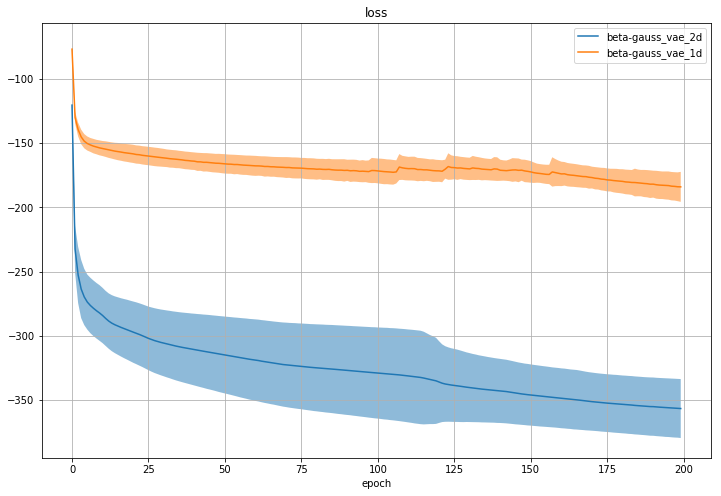

In [69]:
plt.figure(figsize=(12, 8))

for model_name in model_names:
    mean = np.mean(losses[model_name], axis=0)
    std = np.std(losses[model_name], axis=0)
    plt.plot(mean)
    plt.fill_between(
        np.arange(num_epochs), mean - std, mean + std, alpha=0.5
    )
plt.legend(model_names)
plt.grid(True)
plt.title('loss')
plt.xlabel('epoch')

In [70]:
for model_name in model_names:
    print('{}:'.format(model_name))
    mean = np.mean(losses[model_name], axis=0)[-1]
    std = np.std(losses[model_name], axis=0)[-1]
    print('test elbo: {:.4f}+-{:.4f}'.format(-mean, std))
    if track_loglikelihoods:
        mean = np.mean(loglikelihoods[model_name])
        std = np.std(loglikelihoods[model_name])
        print('test loglikelihood: {:.4f}+-{:.4f}'.format(mean, std))

beta-gauss_vae_2d:
test elbo: 356.5336+-22.9595
beta-gauss_vae_1d:
test elbo: 183.9839+-11.6638


** Visualize data embedded into latent space: **

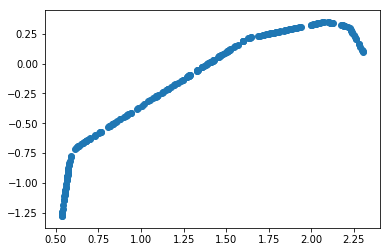

In [71]:
with torch.no_grad():
    X, components = next(iter(toy_samples_batch_gen()()))
    X = X.to(device)

    Z_1, Z_2 = vae.encoder(X)
    Z = dist.Beta(Z_1, Z_2).sample()
    #Z = Z_mean
    Z = vae.decoder_tail(Z)

    for k in range(toy_samples_batch_gen.num_components):
        plt.scatter(*np.split(Z.cpu().numpy()[components == k], 2, axis=1))

## WAE as an auxiliary generative model:

** We use WAE-MMD variant: **

In [28]:
def kernel(X, Y, C):
    return C / (C + torch.sum((X.view(1, *X.shape) - Y.view(Y.shape[0], 1, Y.shape[1])) ** 2, dim=2))

In [29]:
def maximum_mean_discrepancy(X, Y):
    assert X.shape == Y.shape
    n = X.shape[0]
    X_kernel = kernel(X, X, C=manifold_dim)
    X_term = (torch.sum(X_kernel) - torch.trace(X_kernel)) / (n * (n-1))
    Y_kernel = kernel(Y, Y, C=manifold_dim)
    Y_term = (torch.sum(Y_kernel) - torch.trace(Y_kernel)) / (n * (n-1))
    XY_kernel = kernel(X, Y, C=manifold_dim)
    XY_term = 2 * torch.sum(XY_kernel) / (n * n)
    return X_term + Y_term - XY_term
    

In [30]:
class WAE_MMD(nn.Module):
    def __init__(self, feature_dim, latent_dim, hidden_dim=50):
        super(type(self), self).__init__()
        
        self.latent_dim = latent_dim
        self.feature_dim = feature_dim
        
        self._encoder = EncoderFC(feature_dim, latent_dim, hidden_dim)
        self._decoder = DecoderFC(latent_dim, feature_dim, hidden_dim)
        
        self.prior_distr = torch.distributions.Beta(
            torch.ones(latent_dim).to(device), torch.ones(latent_dim).to(device)
        )
        
    def _project(self, Z):
        return Z
        
    def encode(self, X):
        return self._project(self._encoder(X)[0])
    
    def decode(self, Z):
        return self._decoder(Z)[0]
        
    def reconstruct(self, X):
        return self.decode(self.encode(X))
    
    def forward(self, X):
        return self.reconstruct(X)
    
    def sample_prior(self, batch_size):
        beta_sample = self.prior_distr.sample(batch_size)
        return self._project(beta_sample)
    
    def sample(self, batch_size):
        Z_prior = self.sample_prior(torch.Size((batch_size,))).to(device)
        return self.decode(Z_prior)
    
    def cum_batch_loss(self, X):
        batch_size = X.shape[0]
        
        Z = self.encode(X)
        X_rec = self.decode(Z)
        loss_rec = torch.sum((X - X_rec) ** 2)
        
        Z_prior = self.sample_prior(torch.Size((batch_size,))).to(X.device)
        loss_discriminator = -maximum_mean_discrepancy(Z, Z_prior) * batch_size
        
        X_sample = self.decode(Z_prior)
        Z_rec = self.encode(X_sample)
        loss_latent_rec = torch.sum((Z_prior - Z_rec) ** 2)
        
        return loss_rec, loss_discriminator, loss_latent_rec


** We need to generate samples uniformly from $\mathcal{M}$; 1-dim sphere in our case: **

In [31]:
class LatentSamplesBatchGenerator():
    def __init__(self, sample_dim, batch_size, batches_per_epoch):
        super(type(self), self).__init__()
        self.sample_dim = sample_dim
        self.batch_size = batch_size
        self.batches_per_epoch = batches_per_epoch
        
    def __call__(self):
        def generator():
            for count in range(self.batches_per_epoch):
                batch = np.random.normal(size=(self.batch_size, self.sample_dim))
                batch = batch / np.sqrt(np.sum(batch ** 2, axis=1, keepdims=True))
                yield torch.from_numpy(batch).float()
        return generator

In [32]:
latent_samples_batch_gen = LatentSamplesBatchGenerator(manifold_dim+1, batch_size, 1000)

** We train WAE decoder to map a sample from uniform distribution on [0,1] in hidden latent space Z_hid to a uniform distribution on a 1-dim sphere in latent space Z: **

In [33]:
# run this cell if WAE was trained before:

wae = WAE_MMD(manifold_dim+1, manifold_dim).to(device)
wae.load_state_dict(torch.load('wae_beta_circle.pt'))

### Training:

epoch = 1
loss_rec: 0.5325; loss_disc: -0.0018; loss_latent_rec: 0.0067


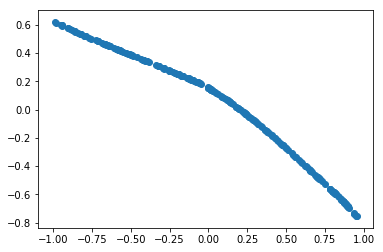

epoch = 2
loss_rec: 0.4251; loss_disc: -0.0002; loss_latent_rec: 0.0013


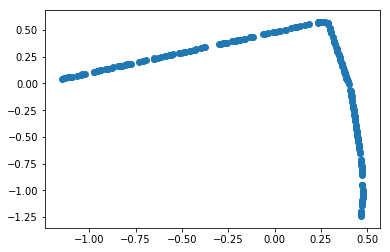

epoch = 3
loss_rec: 0.3043; loss_disc: -0.0001; loss_latent_rec: 0.0041


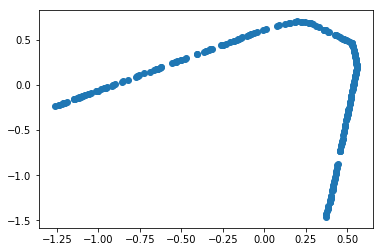

epoch = 4
loss_rec: 0.2442; loss_disc: -0.0001; loss_latent_rec: 0.0035


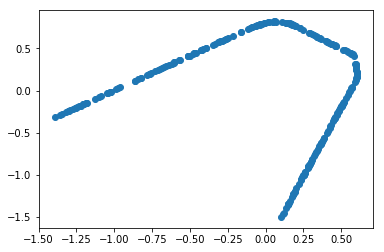

epoch = 5
loss_rec: 0.1985; loss_disc: -0.0001; loss_latent_rec: 0.0027


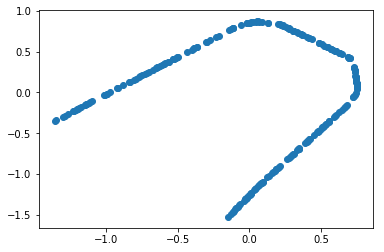

epoch = 6
loss_rec: 0.1647; loss_disc: -0.0001; loss_latent_rec: 0.0019


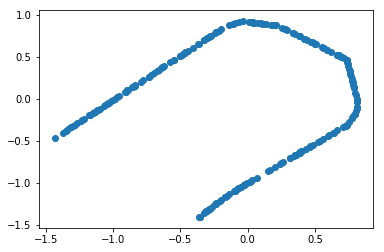

epoch = 7
loss_rec: 0.1335; loss_disc: -0.0001; loss_latent_rec: 0.0011


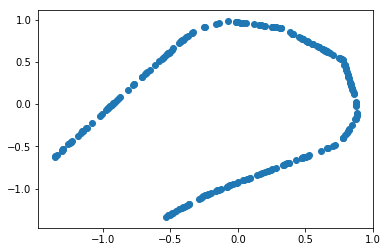

epoch = 8
loss_rec: 0.1103; loss_disc: -0.0002; loss_latent_rec: 0.0009


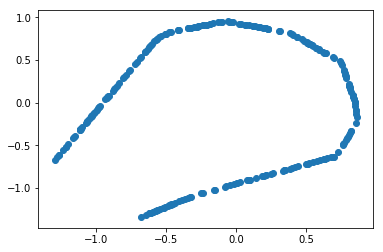

epoch = 9
loss_rec: 0.0981; loss_disc: -0.0002; loss_latent_rec: 0.0007


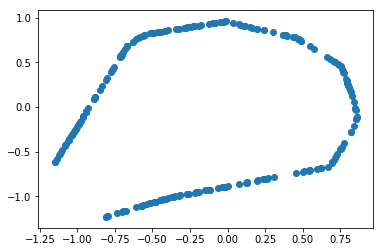

epoch = 10
loss_rec: 0.0872; loss_disc: -0.0002; loss_latent_rec: 0.0005


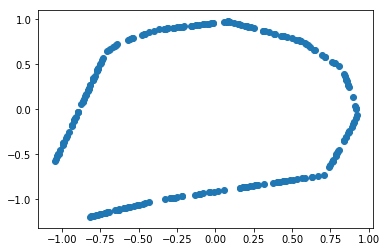

epoch = 11
loss_rec: 0.0782; loss_disc: -0.0002; loss_latent_rec: 0.0004


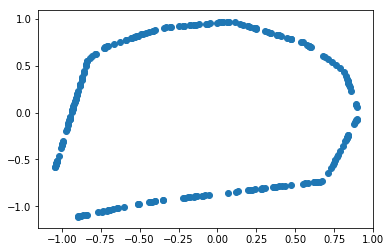

epoch = 12
loss_rec: 0.0713; loss_disc: -0.0003; loss_latent_rec: 0.0003


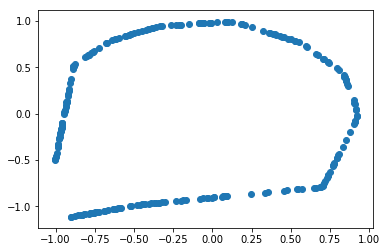

epoch = 13
loss_rec: 0.0667; loss_disc: -0.0003; loss_latent_rec: 0.0002


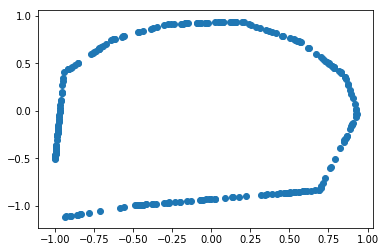

epoch = 14
loss_rec: 0.0634; loss_disc: -0.0003; loss_latent_rec: 0.0002


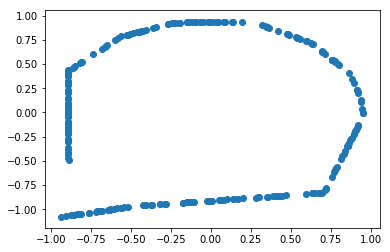

epoch = 15
loss_rec: 0.0605; loss_disc: -0.0003; loss_latent_rec: 0.0002


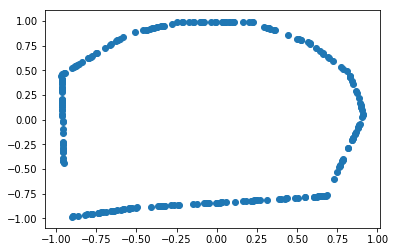

epoch = 16
loss_rec: 0.0574; loss_disc: -0.0003; loss_latent_rec: 0.0002


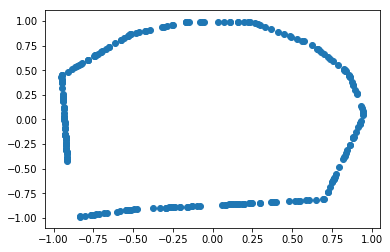

epoch = 17
loss_rec: 0.0566; loss_disc: -0.0002; loss_latent_rec: 0.0002


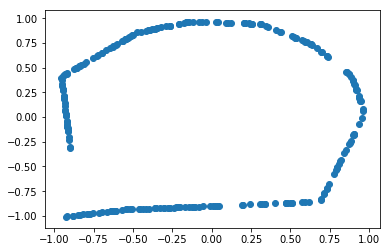

epoch = 18
loss_rec: 0.0531; loss_disc: -0.0003; loss_latent_rec: 0.0002


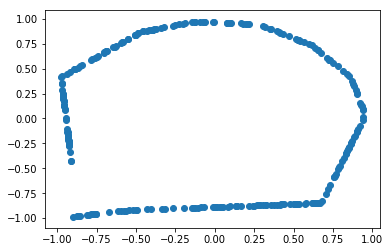

epoch = 19
loss_rec: 0.0527; loss_disc: -0.0003; loss_latent_rec: 0.0002


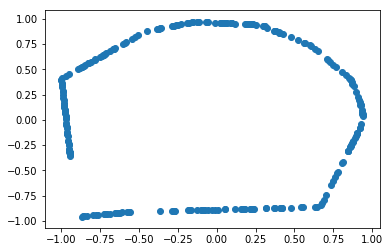

epoch = 20
loss_rec: 0.0515; loss_disc: -0.0003; loss_latent_rec: 0.0002


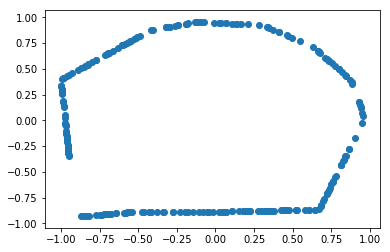

epoch = 21
loss_rec: 0.0484; loss_disc: -0.0003; loss_latent_rec: 0.0002


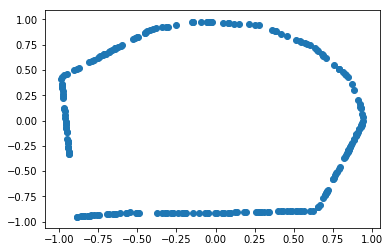

epoch = 22
loss_rec: 0.0484; loss_disc: -0.0003; loss_latent_rec: 0.0001


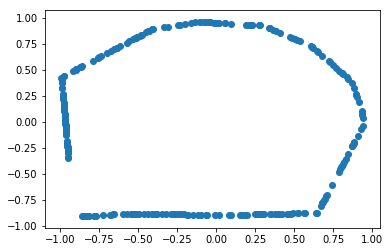

epoch = 23
loss_rec: 0.0468; loss_disc: -0.0002; loss_latent_rec: 0.0001


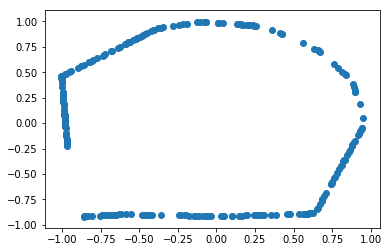

epoch = 24
loss_rec: 0.0460; loss_disc: -0.0003; loss_latent_rec: 0.0001


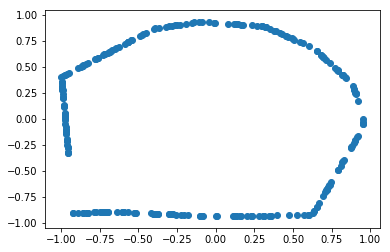

epoch = 25
loss_rec: 0.0451; loss_disc: -0.0004; loss_latent_rec: 0.0002


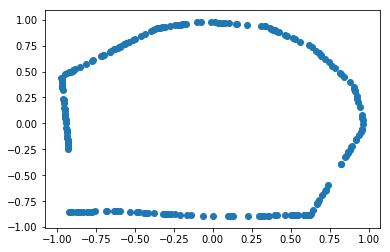

epoch = 26
loss_rec: 0.0436; loss_disc: -0.0003; loss_latent_rec: 0.0001


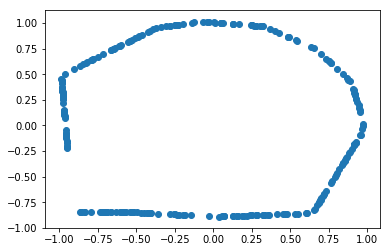

epoch = 27
loss_rec: 0.0428; loss_disc: -0.0004; loss_latent_rec: 0.0001


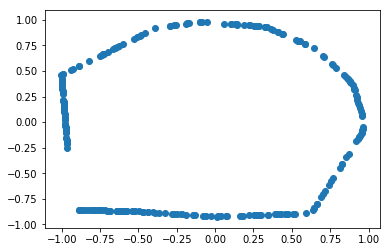

epoch = 28
loss_rec: 0.0428; loss_disc: -0.0003; loss_latent_rec: 0.0001


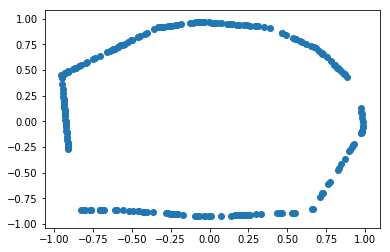

epoch = 29
loss_rec: 0.0419; loss_disc: -0.0003; loss_latent_rec: 0.0001


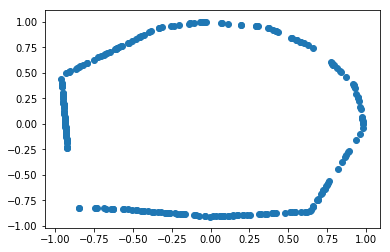

epoch = 30
loss_rec: 0.0421; loss_disc: -0.0003; loss_latent_rec: 0.0001


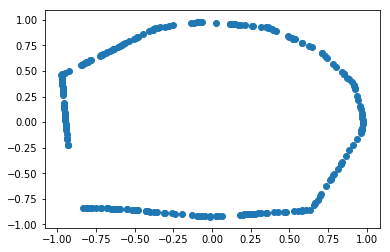

epoch = 31
loss_rec: 0.0406; loss_disc: -0.0003; loss_latent_rec: 0.0001


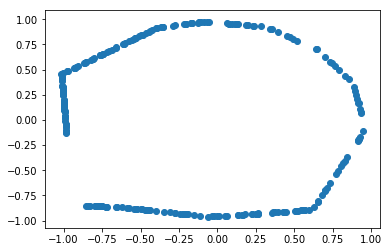

epoch = 32
loss_rec: 0.0395; loss_disc: -0.0003; loss_latent_rec: 0.0001


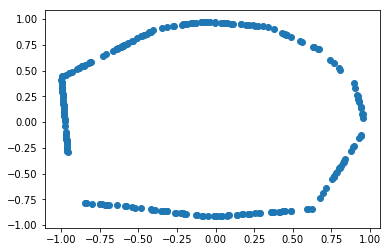

epoch = 33
loss_rec: 0.0393; loss_disc: -0.0003; loss_latent_rec: 0.0001


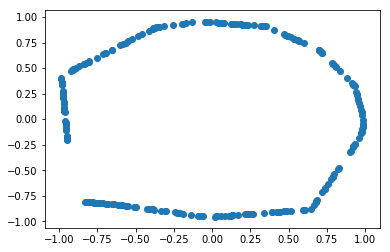

epoch = 34
loss_rec: 0.0377; loss_disc: -0.0002; loss_latent_rec: 0.0001


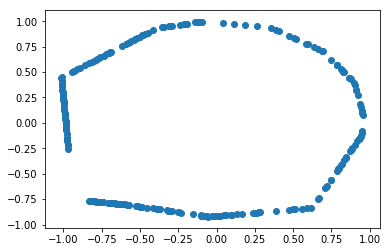

epoch = 35
loss_rec: 0.0375; loss_disc: -0.0003; loss_latent_rec: 0.0001


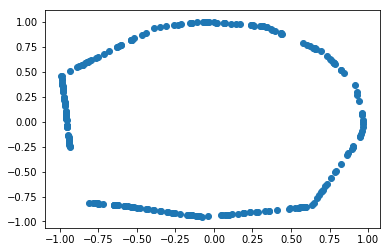

epoch = 36
loss_rec: 0.0384; loss_disc: -0.0003; loss_latent_rec: 0.0001


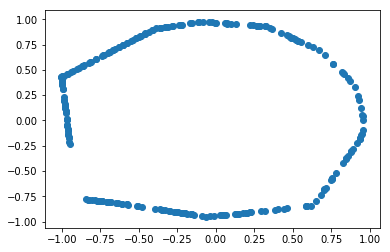

epoch = 37
loss_rec: 0.0376; loss_disc: -0.0003; loss_latent_rec: 0.0001


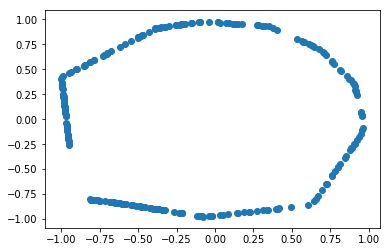

epoch = 38
loss_rec: 0.0363; loss_disc: -0.0003; loss_latent_rec: 0.0001


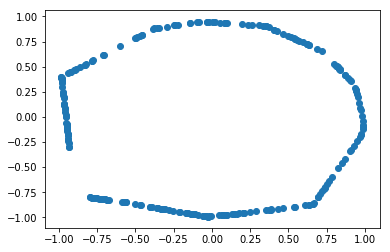

epoch = 39
loss_rec: 0.0364; loss_disc: -0.0003; loss_latent_rec: 0.0001


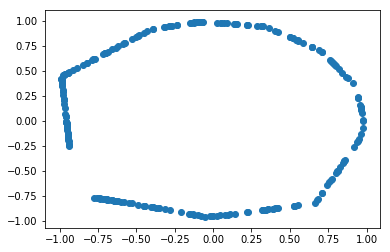

epoch = 40
loss_rec: 0.0365; loss_disc: -0.0002; loss_latent_rec: 0.0001


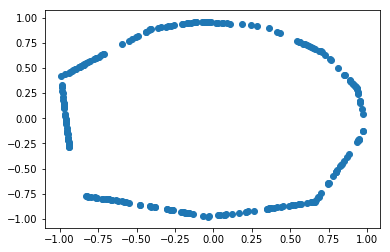

epoch = 41
loss_rec: 0.0344; loss_disc: -0.0002; loss_latent_rec: 0.0001


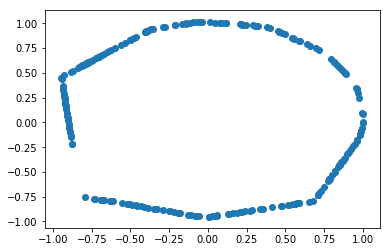

epoch = 42
loss_rec: 0.0349; loss_disc: -0.0003; loss_latent_rec: 0.0001


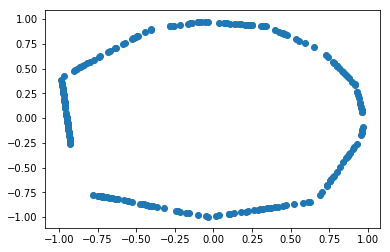

epoch = 43
loss_rec: 0.0339; loss_disc: -0.0003; loss_latent_rec: 0.0001


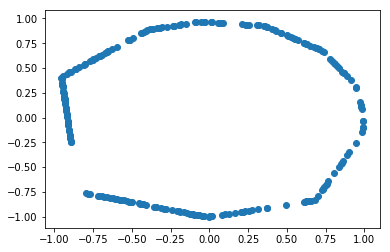

epoch = 44
loss_rec: 0.0345; loss_disc: -0.0002; loss_latent_rec: 0.0001


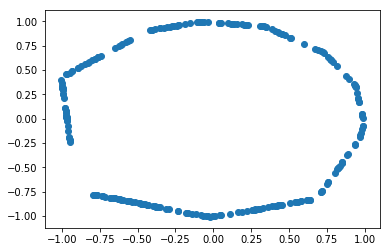

epoch = 45
loss_rec: 0.0346; loss_disc: -0.0002; loss_latent_rec: 0.0001


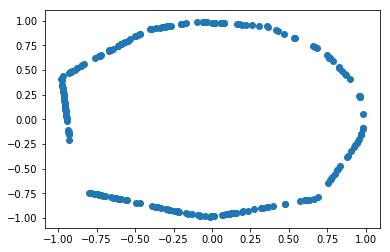

epoch = 46
loss_rec: 0.0345; loss_disc: -0.0002; loss_latent_rec: 0.0001


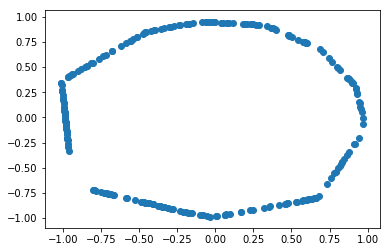

epoch = 47
loss_rec: 0.0339; loss_disc: -0.0003; loss_latent_rec: 0.0001


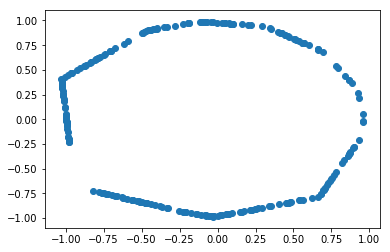

epoch = 48
loss_rec: 0.0339; loss_disc: -0.0002; loss_latent_rec: 0.0001


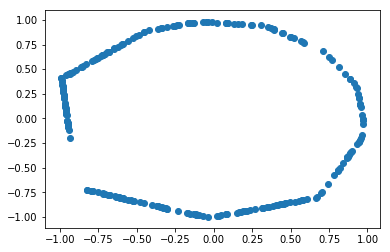

epoch = 49
loss_rec: 0.0339; loss_disc: -0.0002; loss_latent_rec: 0.0001


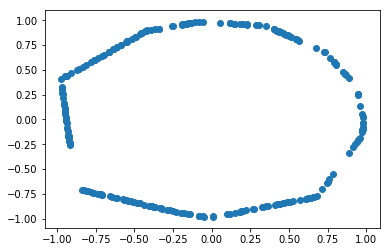

epoch = 50
loss_rec: 0.0327; loss_disc: -0.0002; loss_latent_rec: 0.0001


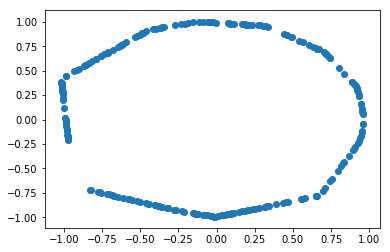

epoch = 51
loss_rec: 0.0321; loss_disc: -0.0003; loss_latent_rec: 0.0001


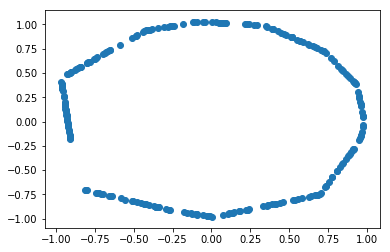

epoch = 52
loss_rec: 0.0333; loss_disc: -0.0002; loss_latent_rec: 0.0001


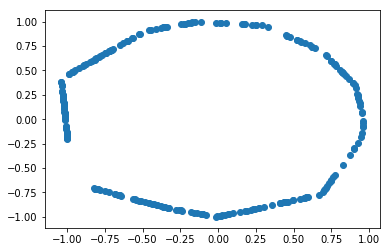

epoch = 53
loss_rec: 0.0331; loss_disc: -0.0003; loss_latent_rec: 0.0001


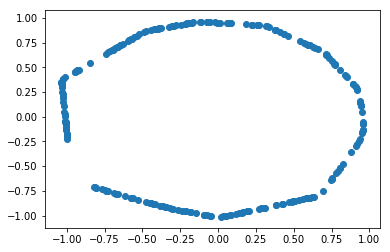

epoch = 54
loss_rec: 0.0318; loss_disc: -0.0002; loss_latent_rec: 0.0001


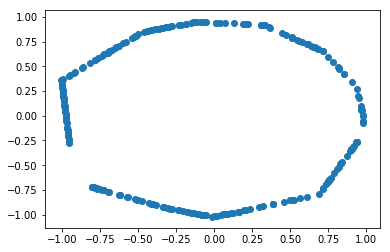

epoch = 55
loss_rec: 0.0303; loss_disc: -0.0002; loss_latent_rec: 0.0001


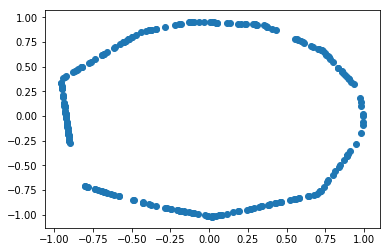

epoch = 56
loss_rec: 0.0320; loss_disc: -0.0003; loss_latent_rec: 0.0001


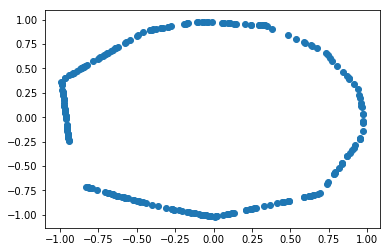

epoch = 57
loss_rec: 0.0315; loss_disc: -0.0003; loss_latent_rec: 0.0001


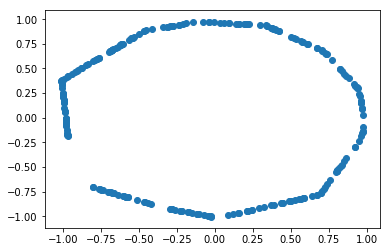

epoch = 58
loss_rec: 0.0312; loss_disc: -0.0003; loss_latent_rec: 0.0001


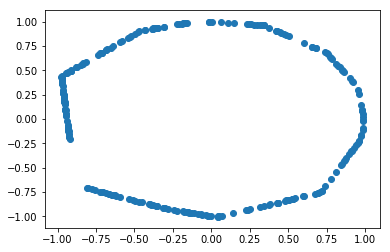

epoch = 59
loss_rec: 0.0312; loss_disc: -0.0003; loss_latent_rec: 0.0001


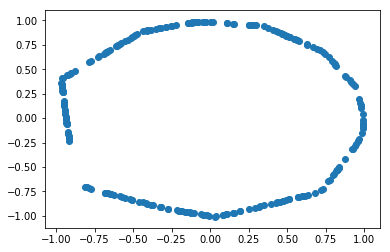

epoch = 60
loss_rec: 0.0307; loss_disc: -0.0003; loss_latent_rec: 0.0001


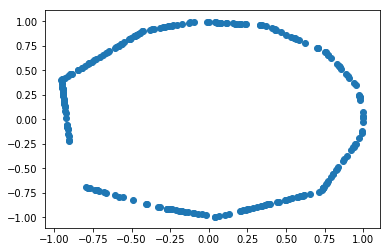

epoch = 61
loss_rec: 0.0305; loss_disc: -0.0002; loss_latent_rec: 0.0001


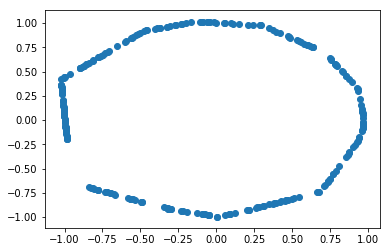

epoch = 62
loss_rec: 0.0303; loss_disc: -0.0003; loss_latent_rec: 0.0001


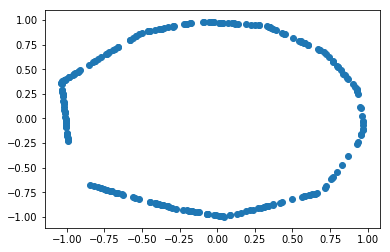

epoch = 63
loss_rec: 0.0285; loss_disc: -0.0003; loss_latent_rec: 0.0001


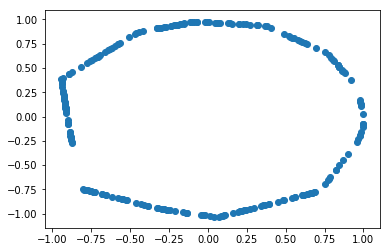

epoch = 64
loss_rec: 0.0307; loss_disc: -0.0002; loss_latent_rec: 0.0001


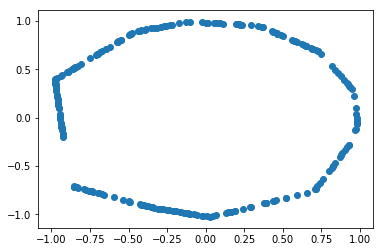

epoch = 65
loss_rec: 0.0296; loss_disc: -0.0002; loss_latent_rec: 0.0001


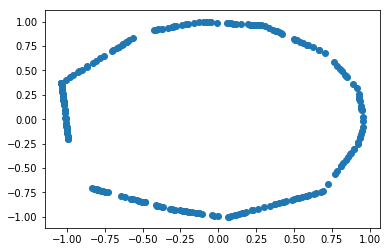

epoch = 66
loss_rec: 0.0291; loss_disc: -0.0003; loss_latent_rec: 0.0001


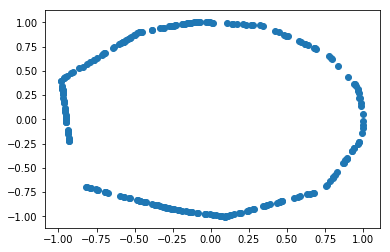

epoch = 67
loss_rec: 0.0281; loss_disc: -0.0002; loss_latent_rec: 0.0001


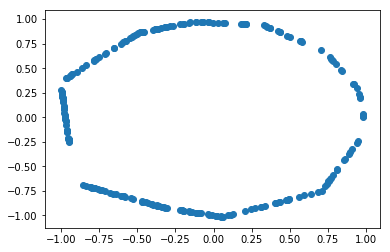

epoch = 68
loss_rec: 0.0297; loss_disc: -0.0002; loss_latent_rec: 0.0001


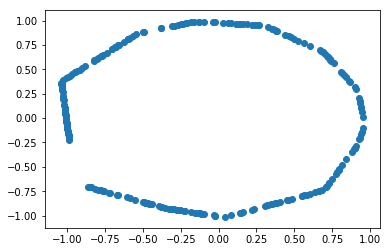

epoch = 69
loss_rec: 0.0283; loss_disc: -0.0002; loss_latent_rec: 0.0001


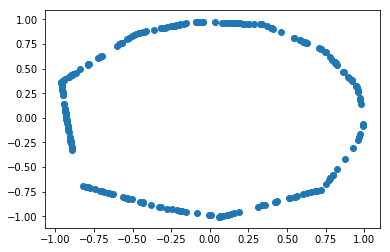

epoch = 70
loss_rec: 0.0286; loss_disc: -0.0002; loss_latent_rec: 0.0001


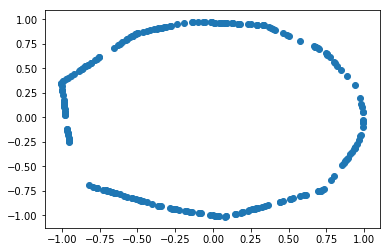

epoch = 71
loss_rec: 0.0290; loss_disc: -0.0002; loss_latent_rec: 0.0001


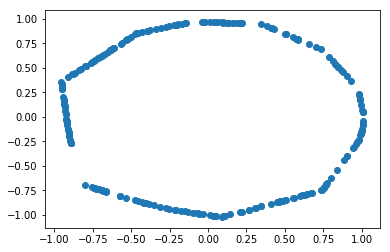

epoch = 72
loss_rec: 0.0291; loss_disc: -0.0002; loss_latent_rec: 0.0001


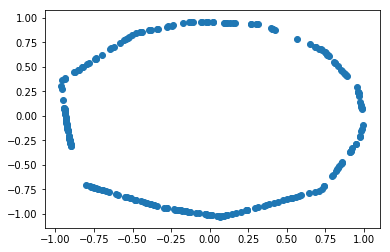

epoch = 73
loss_rec: 0.0286; loss_disc: -0.0002; loss_latent_rec: 0.0001


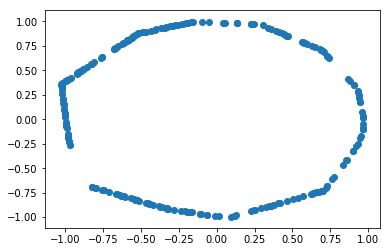

epoch = 74
loss_rec: 0.0289; loss_disc: -0.0002; loss_latent_rec: 0.0001


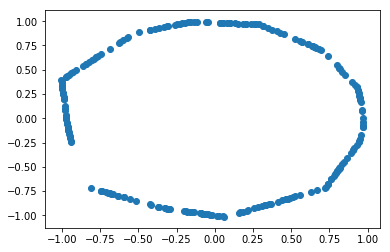

epoch = 75
loss_rec: 0.0280; loss_disc: -0.0002; loss_latent_rec: 0.0001


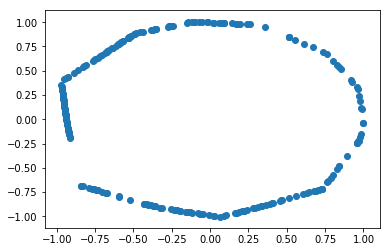

epoch = 76
loss_rec: 0.0273; loss_disc: -0.0002; loss_latent_rec: 0.0001


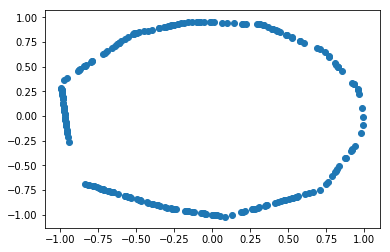

epoch = 77
loss_rec: 0.0275; loss_disc: -0.0002; loss_latent_rec: 0.0001


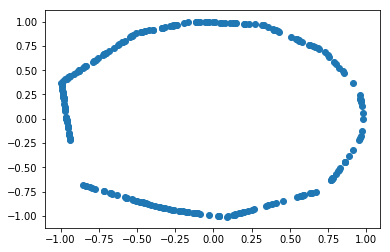

epoch = 78
loss_rec: 0.0286; loss_disc: -0.0002; loss_latent_rec: 0.0001


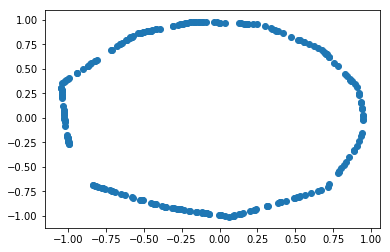

epoch = 79
loss_rec: 0.0270; loss_disc: -0.0002; loss_latent_rec: 0.0001


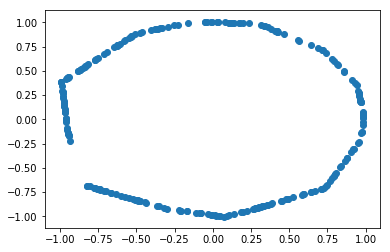

epoch = 80
loss_rec: 0.0263; loss_disc: -0.0002; loss_latent_rec: 0.0001


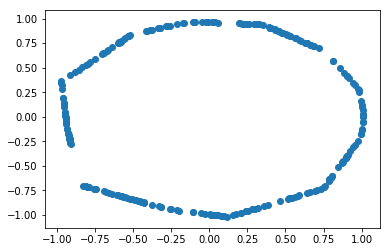

epoch = 81
loss_rec: 0.0266; loss_disc: -0.0002; loss_latent_rec: 0.0001


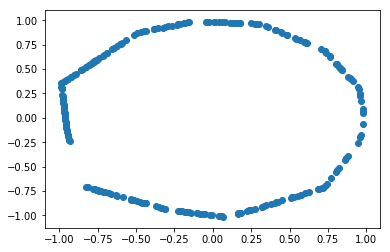

epoch = 82
loss_rec: 0.0274; loss_disc: -0.0002; loss_latent_rec: 0.0001


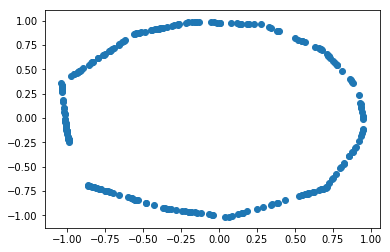

epoch = 83
loss_rec: 0.0267; loss_disc: -0.0002; loss_latent_rec: 0.0001


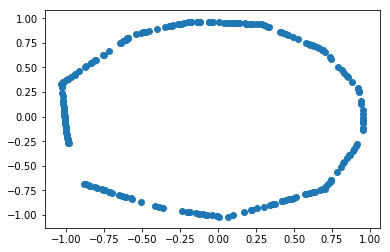

epoch = 84
loss_rec: 0.0259; loss_disc: -0.0001; loss_latent_rec: 0.0001


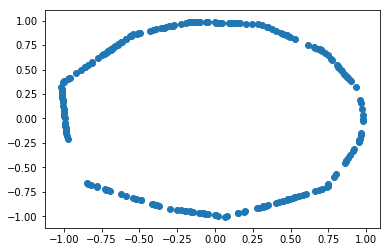

epoch = 85
loss_rec: 0.0266; loss_disc: -0.0002; loss_latent_rec: 0.0001


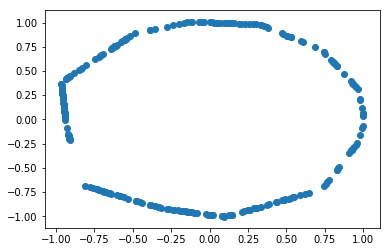

epoch = 86
loss_rec: 0.0273; loss_disc: -0.0002; loss_latent_rec: 0.0001


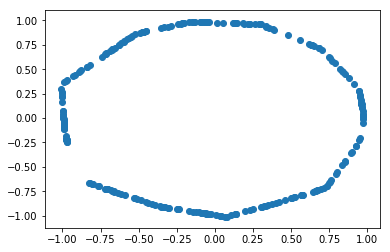

epoch = 87
loss_rec: 0.0274; loss_disc: -0.0002; loss_latent_rec: 0.0001


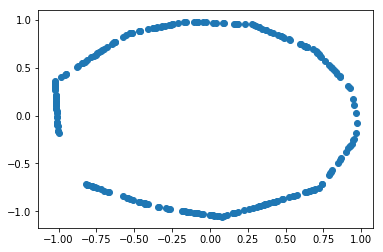

epoch = 88
loss_rec: 0.0264; loss_disc: -0.0002; loss_latent_rec: 0.0001


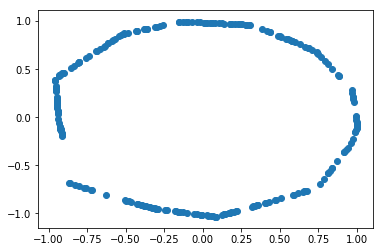

epoch = 89
loss_rec: 0.0265; loss_disc: -0.0002; loss_latent_rec: 0.0001


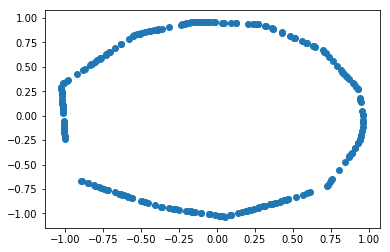

epoch = 90
loss_rec: 0.0250; loss_disc: -0.0002; loss_latent_rec: 0.0001


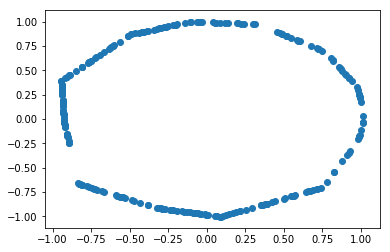

epoch = 91
loss_rec: 0.0266; loss_disc: -0.0002; loss_latent_rec: 0.0001


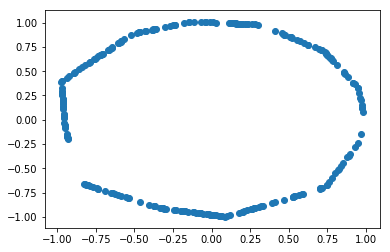

epoch = 92
loss_rec: 0.0265; loss_disc: -0.0002; loss_latent_rec: 0.0001


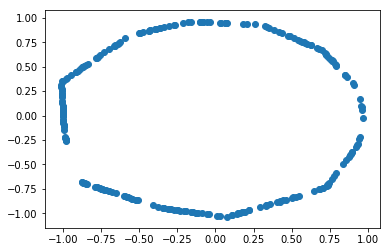

epoch = 93
loss_rec: 0.0272; loss_disc: -0.0002; loss_latent_rec: 0.0001


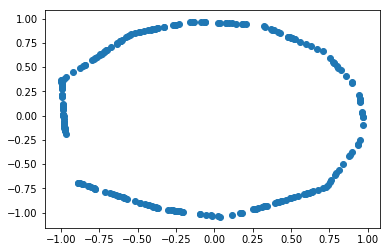

epoch = 94
loss_rec: 0.0257; loss_disc: -0.0003; loss_latent_rec: 0.0001


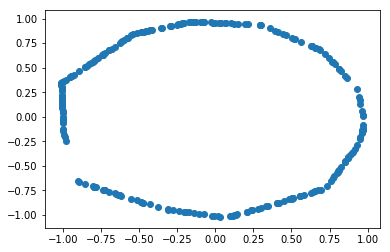

epoch = 95
loss_rec: 0.0261; loss_disc: -0.0002; loss_latent_rec: 0.0001


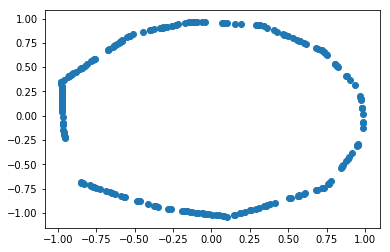

epoch = 96
loss_rec: 0.0248; loss_disc: -0.0002; loss_latent_rec: 0.0001


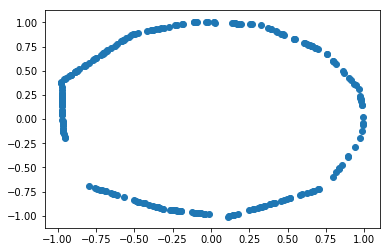

epoch = 97
loss_rec: 0.0254; loss_disc: -0.0001; loss_latent_rec: 0.0001


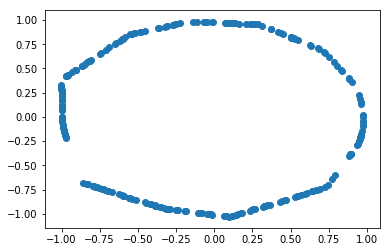

epoch = 98
loss_rec: 0.0257; loss_disc: -0.0002; loss_latent_rec: 0.0001


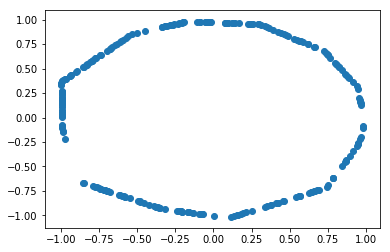

epoch = 99
loss_rec: 0.0251; loss_disc: -0.0001; loss_latent_rec: 0.0001


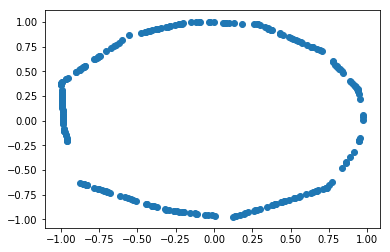

epoch = 100
loss_rec: 0.0255; loss_disc: -0.0002; loss_latent_rec: 0.0001


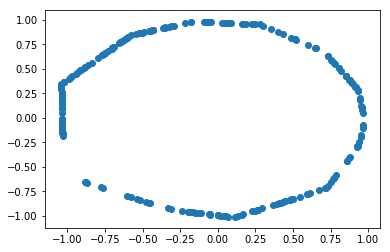

epoch = 101
loss_rec: 0.0254; loss_disc: -0.0002; loss_latent_rec: 0.0001


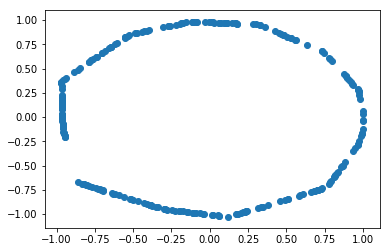

epoch = 102
loss_rec: 0.0257; loss_disc: -0.0002; loss_latent_rec: 0.0001


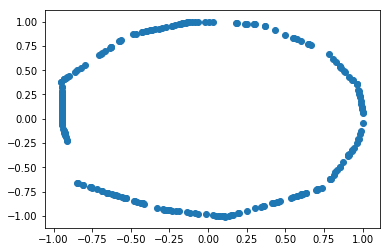

epoch = 103
loss_rec: 0.0249; loss_disc: -0.0003; loss_latent_rec: 0.0001


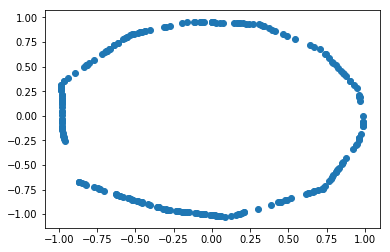

epoch = 104
loss_rec: 0.0250; loss_disc: -0.0002; loss_latent_rec: 0.0001


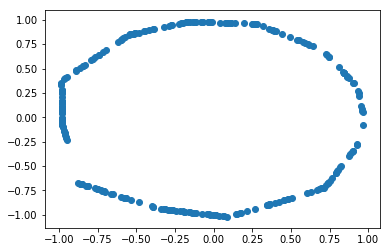

epoch = 105
loss_rec: 0.0248; loss_disc: -0.0002; loss_latent_rec: 0.0001


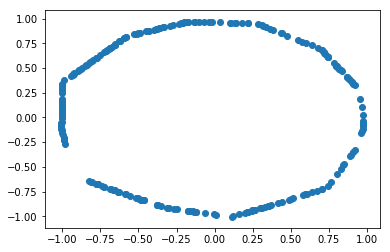

epoch = 106
loss_rec: 0.0245; loss_disc: -0.0002; loss_latent_rec: 0.0001


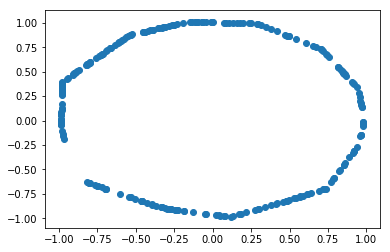

epoch = 107
loss_rec: 0.0254; loss_disc: -0.0002; loss_latent_rec: 0.0001


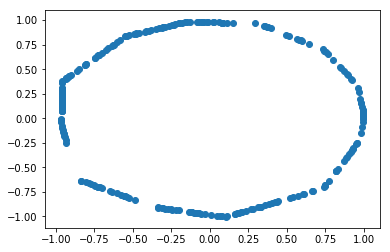

epoch = 108
loss_rec: 0.0251; loss_disc: -0.0002; loss_latent_rec: 0.0001


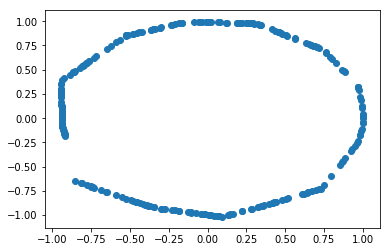

epoch = 109
loss_rec: 0.0239; loss_disc: -0.0003; loss_latent_rec: 0.0001


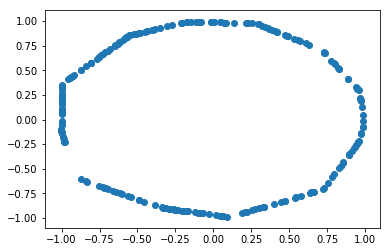

epoch = 110
loss_rec: 0.0240; loss_disc: -0.0002; loss_latent_rec: 0.0001


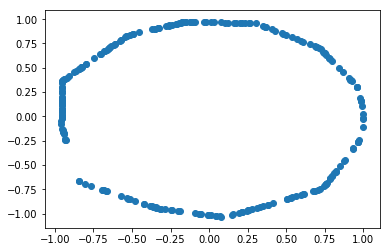

epoch = 111
loss_rec: 0.0245; loss_disc: -0.0001; loss_latent_rec: 0.0001


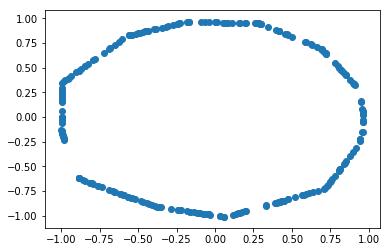

epoch = 112
loss_rec: 0.0251; loss_disc: -0.0001; loss_latent_rec: 0.0001


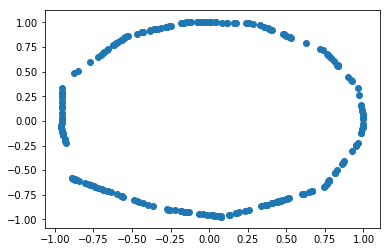

epoch = 113
loss_rec: 0.0239; loss_disc: -0.0002; loss_latent_rec: 0.0001


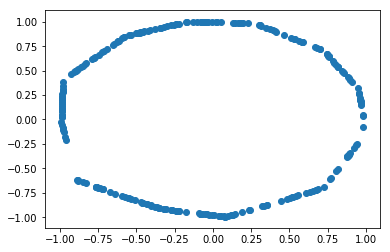

epoch = 114
loss_rec: 0.0243; loss_disc: -0.0002; loss_latent_rec: 0.0001


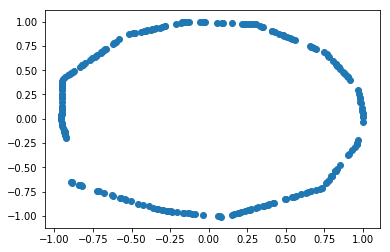

epoch = 115
loss_rec: 0.0245; loss_disc: -0.0002; loss_latent_rec: 0.0001


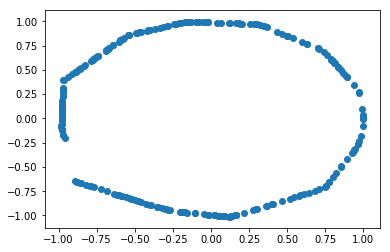

epoch = 116
loss_rec: 0.0236; loss_disc: -0.0001; loss_latent_rec: 0.0001


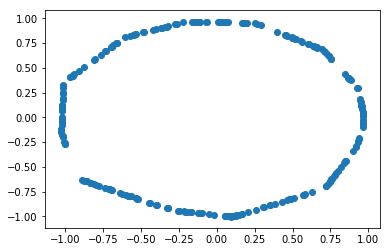

epoch = 117
loss_rec: 0.0245; loss_disc: -0.0002; loss_latent_rec: 0.0001


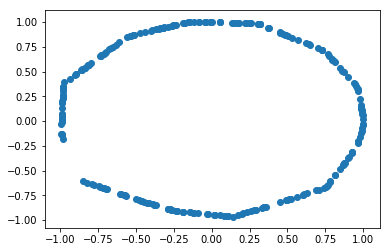

epoch = 118
loss_rec: 0.0245; loss_disc: -0.0002; loss_latent_rec: 0.0001


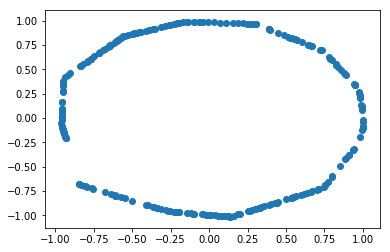

epoch = 119
loss_rec: 0.0245; loss_disc: -0.0002; loss_latent_rec: 0.0001


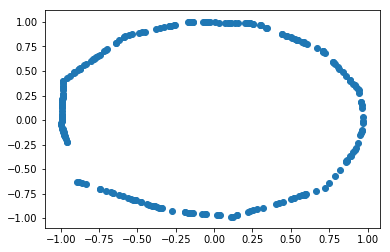

epoch = 120
loss_rec: 0.0234; loss_disc: -0.0002; loss_latent_rec: 0.0001


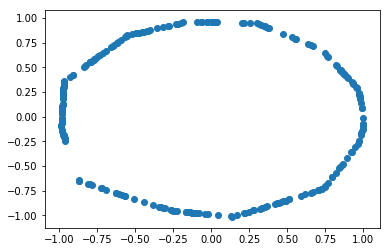

epoch = 121
loss_rec: 0.0233; loss_disc: -0.0001; loss_latent_rec: 0.0001


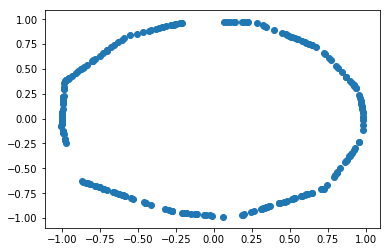

epoch = 122
loss_rec: 0.0229; loss_disc: -0.0001; loss_latent_rec: 0.0001


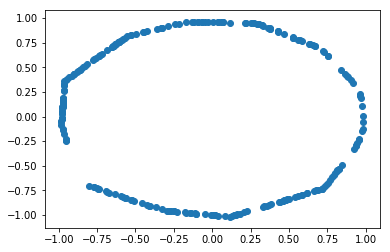

epoch = 123
loss_rec: 0.0234; loss_disc: -0.0001; loss_latent_rec: 0.0001


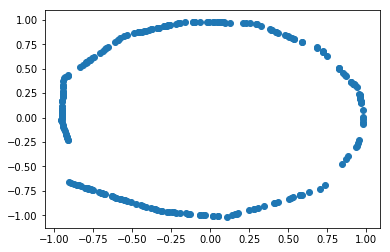

epoch = 124
loss_rec: 0.0232; loss_disc: -0.0002; loss_latent_rec: 0.0001


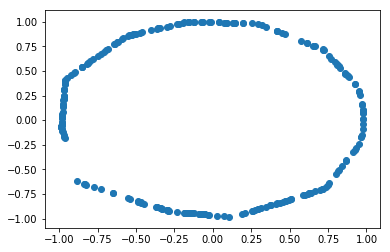

epoch = 125
loss_rec: 0.0230; loss_disc: -0.0002; loss_latent_rec: 0.0001


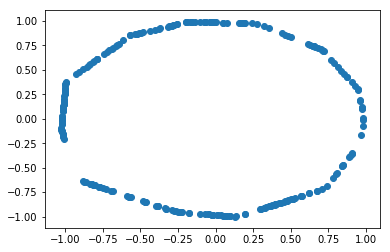

epoch = 126
loss_rec: 0.0237; loss_disc: -0.0002; loss_latent_rec: 0.0001


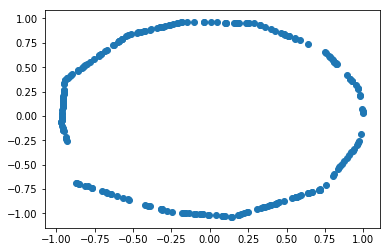

epoch = 127
loss_rec: 0.0238; loss_disc: -0.0001; loss_latent_rec: 0.0001


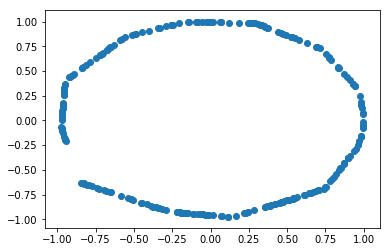

epoch = 128
loss_rec: 0.0244; loss_disc: -0.0001; loss_latent_rec: 0.0001


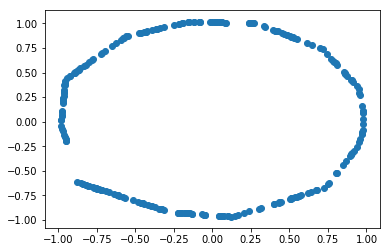

epoch = 129
loss_rec: 0.0229; loss_disc: -0.0002; loss_latent_rec: 0.0001


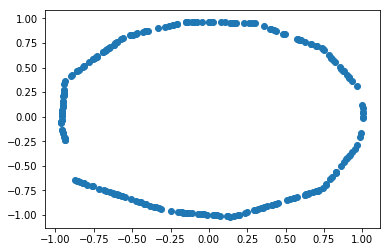

epoch = 130
loss_rec: 0.0234; loss_disc: -0.0002; loss_latent_rec: 0.0001


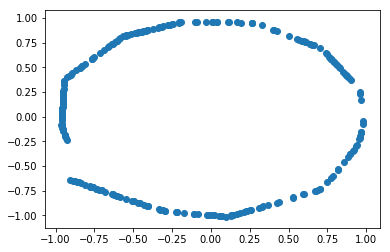

epoch = 131
loss_rec: 0.0228; loss_disc: -0.0001; loss_latent_rec: 0.0001


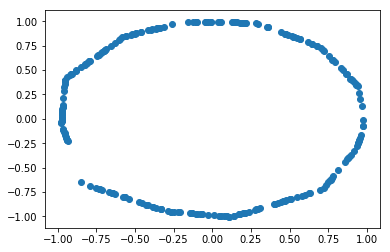

epoch = 132
loss_rec: 0.0220; loss_disc: -0.0002; loss_latent_rec: 0.0001


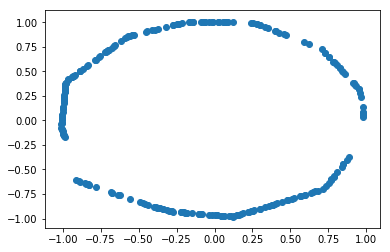

epoch = 133
loss_rec: 0.0230; loss_disc: -0.0002; loss_latent_rec: 0.0001


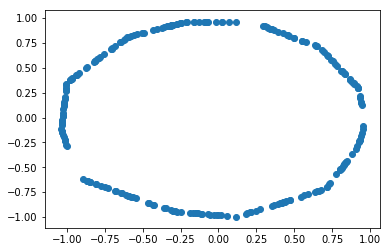

epoch = 134
loss_rec: 0.0226; loss_disc: -0.0001; loss_latent_rec: 0.0001


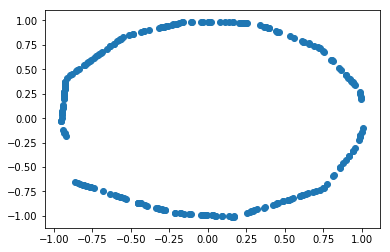

epoch = 135
loss_rec: 0.0223; loss_disc: -0.0001; loss_latent_rec: 0.0001


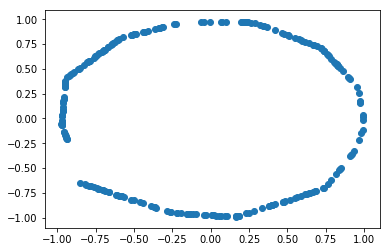

epoch = 136
loss_rec: 0.0221; loss_disc: -0.0001; loss_latent_rec: 0.0001


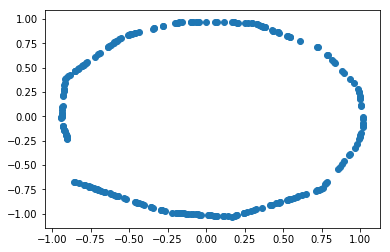

epoch = 137
loss_rec: 0.0226; loss_disc: -0.0002; loss_latent_rec: 0.0001


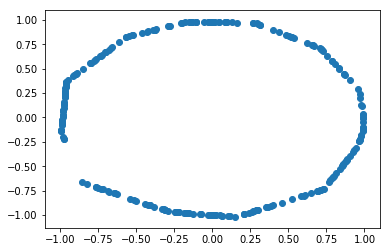

epoch = 138
loss_rec: 0.0222; loss_disc: -0.0002; loss_latent_rec: 0.0001


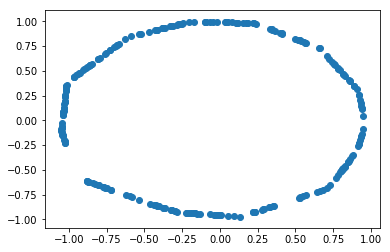

epoch = 139
loss_rec: 0.0228; loss_disc: -0.0002; loss_latent_rec: 0.0001


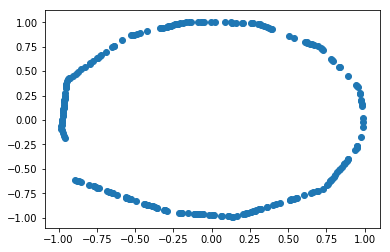

epoch = 140
loss_rec: 0.0217; loss_disc: -0.0001; loss_latent_rec: 0.0001


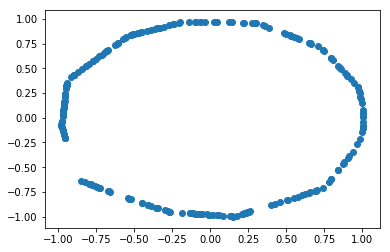

epoch = 141
loss_rec: 0.0228; loss_disc: -0.0002; loss_latent_rec: 0.0001


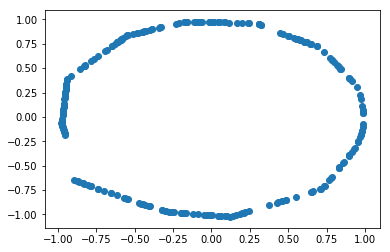

epoch = 142
loss_rec: 0.0230; loss_disc: -0.0001; loss_latent_rec: 0.0001


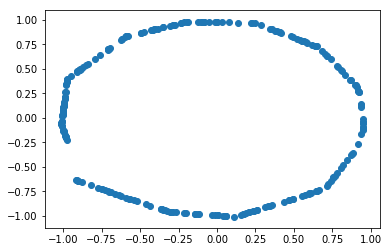

epoch = 143
loss_rec: 0.0223; loss_disc: -0.0002; loss_latent_rec: 0.0001


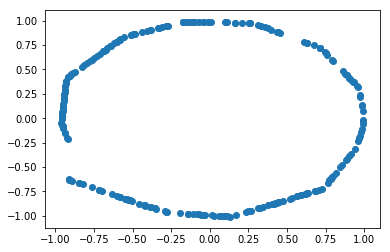

epoch = 144
loss_rec: 0.0229; loss_disc: -0.0001; loss_latent_rec: 0.0001


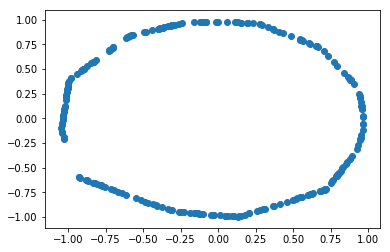

epoch = 145
loss_rec: 0.0227; loss_disc: -0.0001; loss_latent_rec: 0.0001


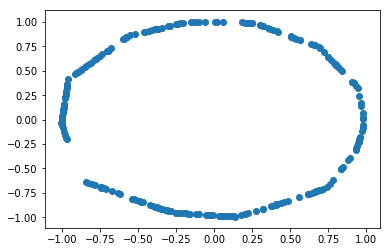

epoch = 146
loss_rec: 0.0210; loss_disc: -0.0001; loss_latent_rec: 0.0001


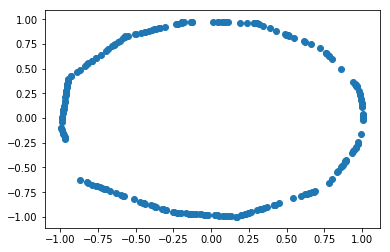

epoch = 147
loss_rec: 0.0224; loss_disc: -0.0001; loss_latent_rec: 0.0001


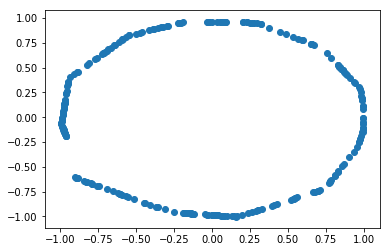

epoch = 148
loss_rec: 0.0223; loss_disc: -0.0002; loss_latent_rec: 0.0001


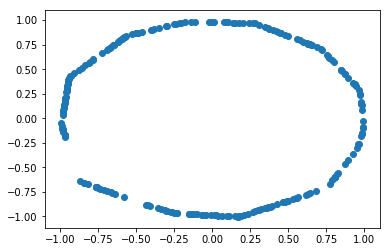

epoch = 149
loss_rec: 0.0209; loss_disc: -0.0001; loss_latent_rec: 0.0001


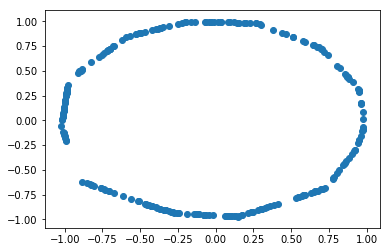

epoch = 150
loss_rec: 0.0222; loss_disc: -0.0001; loss_latent_rec: 0.0001


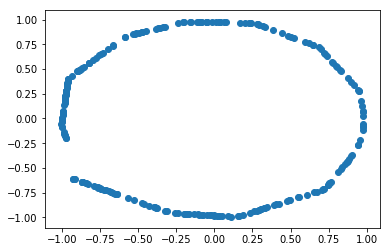

epoch = 151
loss_rec: 0.0223; loss_disc: -0.0001; loss_latent_rec: 0.0001


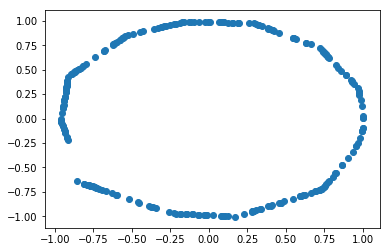

epoch = 152
loss_rec: 0.0223; loss_disc: -0.0002; loss_latent_rec: 0.0001


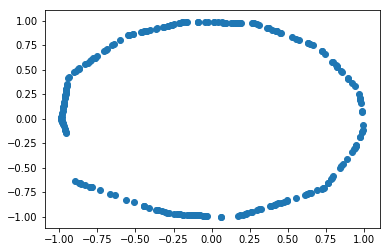

epoch = 153
loss_rec: 0.0219; loss_disc: -0.0002; loss_latent_rec: 0.0001


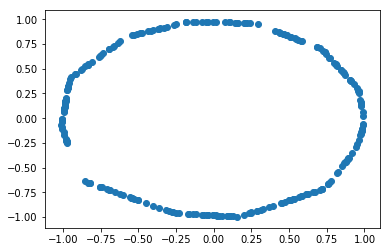

epoch = 154
loss_rec: 0.0225; loss_disc: -0.0002; loss_latent_rec: 0.0001


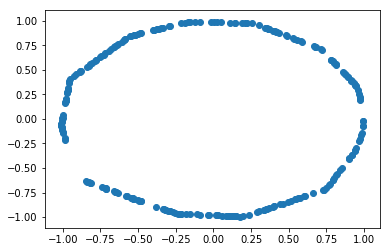

epoch = 155
loss_rec: 0.0222; loss_disc: -0.0001; loss_latent_rec: 0.0001


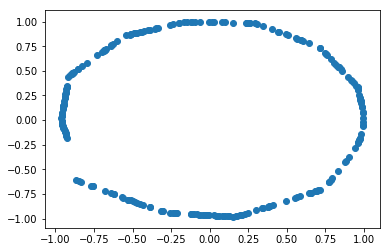

epoch = 156
loss_rec: 0.0216; loss_disc: -0.0001; loss_latent_rec: 0.0001


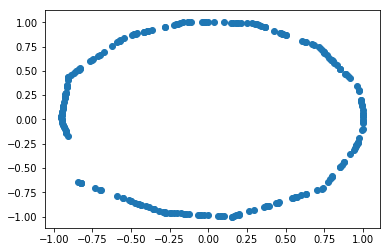

epoch = 157
loss_rec: 0.0225; loss_disc: -0.0001; loss_latent_rec: 0.0001


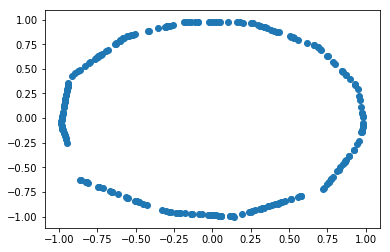

epoch = 158
loss_rec: 0.0223; loss_disc: -0.0001; loss_latent_rec: 0.0001


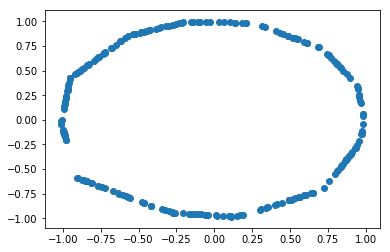

epoch = 159
loss_rec: 0.0217; loss_disc: -0.0002; loss_latent_rec: 0.0001


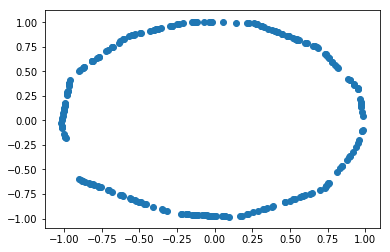

epoch = 160
loss_rec: 0.0213; loss_disc: -0.0001; loss_latent_rec: 0.0001


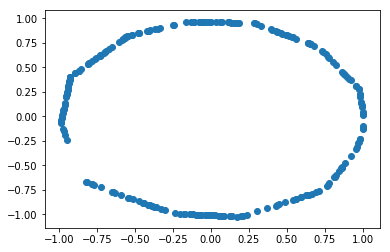

epoch = 161
loss_rec: 0.0213; loss_disc: -0.0001; loss_latent_rec: 0.0001


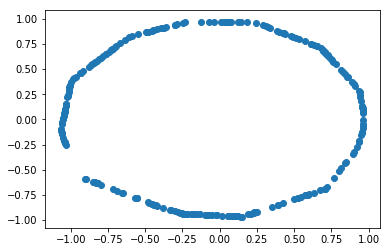

epoch = 162
loss_rec: 0.0216; loss_disc: -0.0001; loss_latent_rec: 0.0001


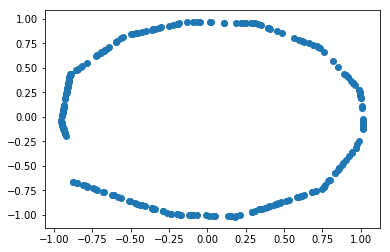

epoch = 163
loss_rec: 0.0219; loss_disc: -0.0001; loss_latent_rec: 0.0001


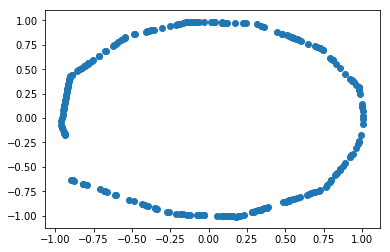

epoch = 164
loss_rec: 0.0215; loss_disc: -0.0002; loss_latent_rec: 0.0001


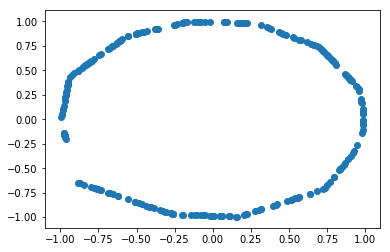

epoch = 165
loss_rec: 0.0208; loss_disc: -0.0001; loss_latent_rec: 0.0001


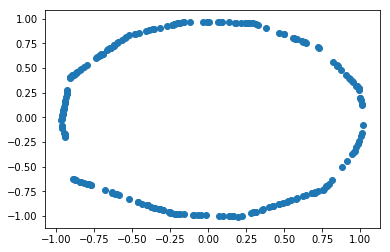

epoch = 166
loss_rec: 0.0210; loss_disc: -0.0002; loss_latent_rec: 0.0001


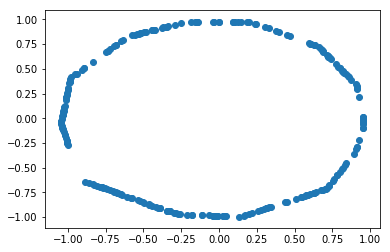

epoch = 167
loss_rec: 0.0218; loss_disc: -0.0001; loss_latent_rec: 0.0001


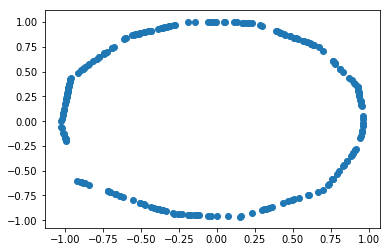

epoch = 168
loss_rec: 0.0213; loss_disc: -0.0001; loss_latent_rec: 0.0001


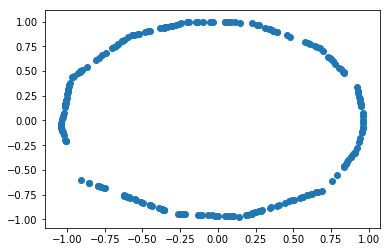

epoch = 169
loss_rec: 0.0210; loss_disc: -0.0002; loss_latent_rec: 0.0001


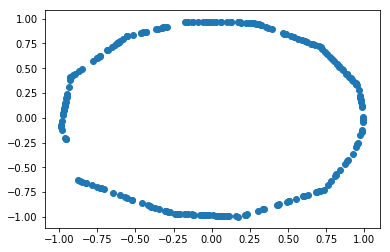

epoch = 170
loss_rec: 0.0209; loss_disc: -0.0001; loss_latent_rec: 0.0001


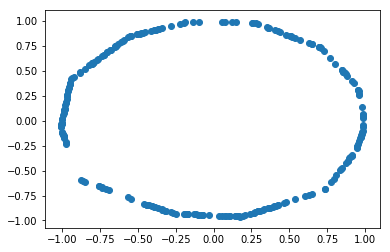

epoch = 171
loss_rec: 0.0213; loss_disc: -0.0001; loss_latent_rec: 0.0001


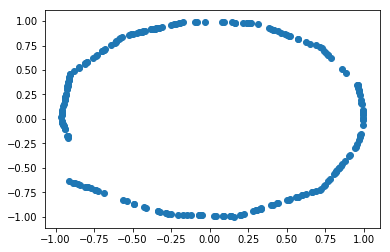

epoch = 172
loss_rec: 0.0208; loss_disc: -0.0002; loss_latent_rec: 0.0001


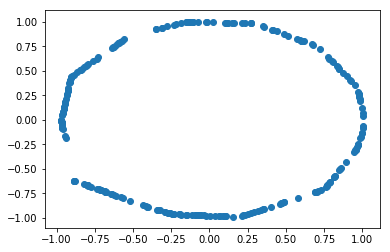

epoch = 173
loss_rec: 0.0215; loss_disc: -0.0002; loss_latent_rec: 0.0001


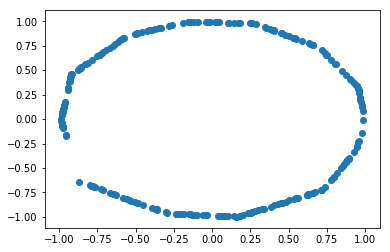

epoch = 174
loss_rec: 0.0216; loss_disc: -0.0001; loss_latent_rec: 0.0001


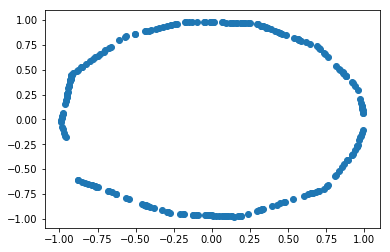

epoch = 175
loss_rec: 0.0216; loss_disc: -0.0002; loss_latent_rec: 0.0001


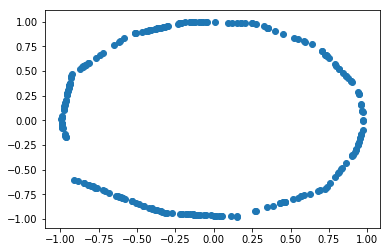

epoch = 176
loss_rec: 0.0210; loss_disc: -0.0001; loss_latent_rec: 0.0001


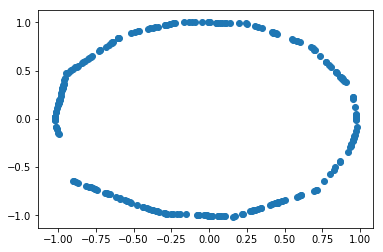

epoch = 177
loss_rec: 0.0213; loss_disc: -0.0001; loss_latent_rec: 0.0001


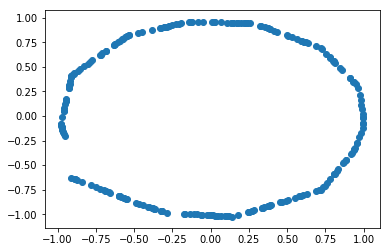

epoch = 178
loss_rec: 0.0216; loss_disc: -0.0001; loss_latent_rec: 0.0001


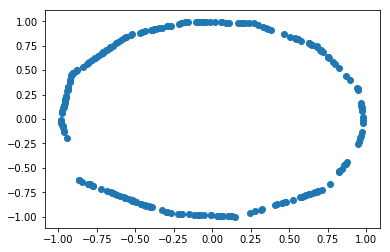

epoch = 179
loss_rec: 0.0209; loss_disc: -0.0002; loss_latent_rec: 0.0001


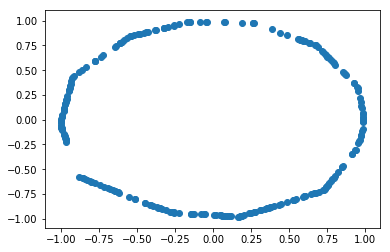

epoch = 180
loss_rec: 0.0210; loss_disc: -0.0001; loss_latent_rec: 0.0001


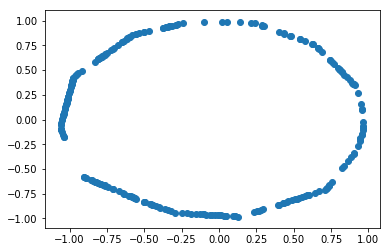

epoch = 181
loss_rec: 0.0212; loss_disc: -0.0001; loss_latent_rec: 0.0001


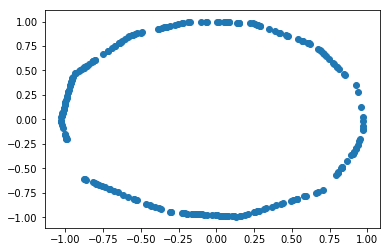

epoch = 182
loss_rec: 0.0208; loss_disc: -0.0001; loss_latent_rec: 0.0001


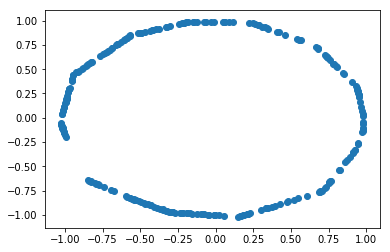

epoch = 183
loss_rec: 0.0199; loss_disc: -0.0001; loss_latent_rec: 0.0001


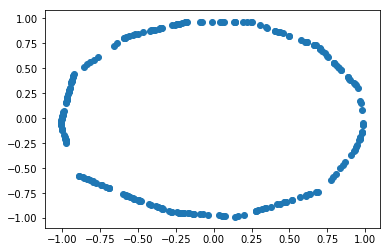

epoch = 184
loss_rec: 0.0210; loss_disc: -0.0001; loss_latent_rec: 0.0001


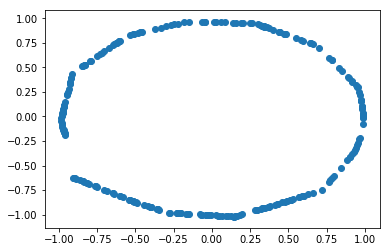

epoch = 185
loss_rec: 0.0204; loss_disc: -0.0001; loss_latent_rec: 0.0001


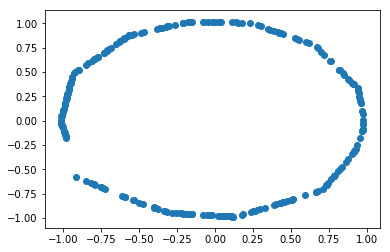

epoch = 186
loss_rec: 0.0208; loss_disc: -0.0002; loss_latent_rec: 0.0001


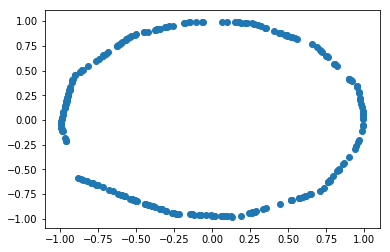

epoch = 187
loss_rec: 0.0208; loss_disc: -0.0001; loss_latent_rec: 0.0001


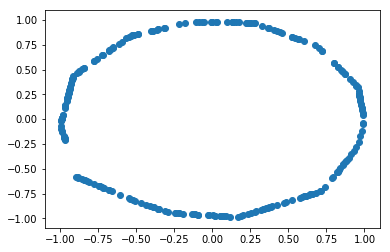

epoch = 188
loss_rec: 0.0200; loss_disc: -0.0001; loss_latent_rec: 0.0001


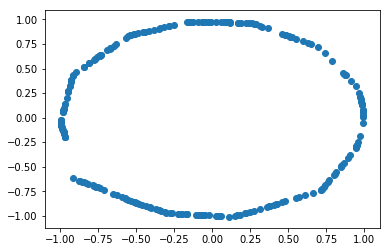

epoch = 189
loss_rec: 0.0210; loss_disc: -0.0001; loss_latent_rec: 0.0001


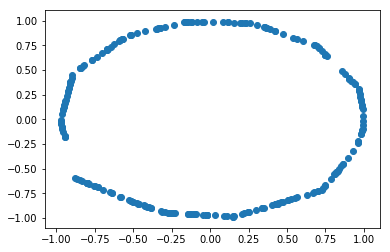

epoch = 190
loss_rec: 0.0210; loss_disc: -0.0001; loss_latent_rec: 0.0001


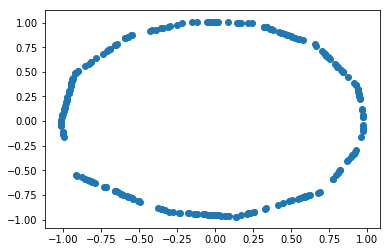

epoch = 191
loss_rec: 0.0205; loss_disc: -0.0001; loss_latent_rec: 0.0001


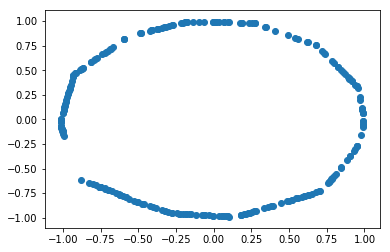

epoch = 192
loss_rec: 0.0199; loss_disc: -0.0001; loss_latent_rec: 0.0001


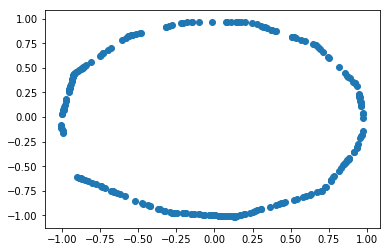

epoch = 193
loss_rec: 0.0199; loss_disc: -0.0000; loss_latent_rec: 0.0001


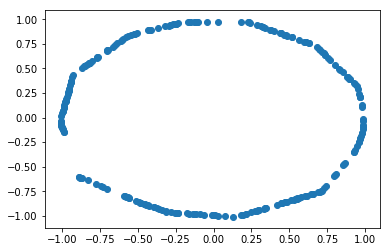

epoch = 194
loss_rec: 0.0200; loss_disc: -0.0001; loss_latent_rec: 0.0001


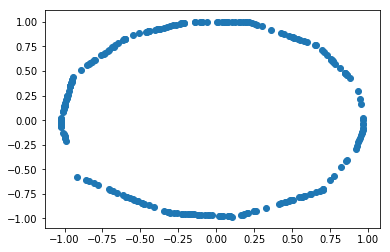

epoch = 195
loss_rec: 0.0198; loss_disc: -0.0001; loss_latent_rec: 0.0001


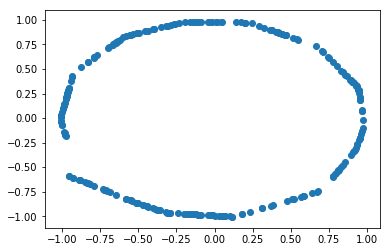

epoch = 196
loss_rec: 0.0201; loss_disc: -0.0001; loss_latent_rec: 0.0001


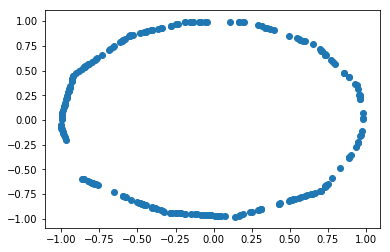

epoch = 197
loss_rec: 0.0196; loss_disc: -0.0001; loss_latent_rec: 0.0001


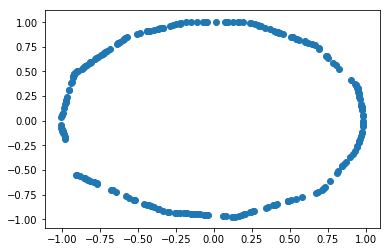

epoch = 198
loss_rec: 0.0205; loss_disc: -0.0001; loss_latent_rec: 0.0001


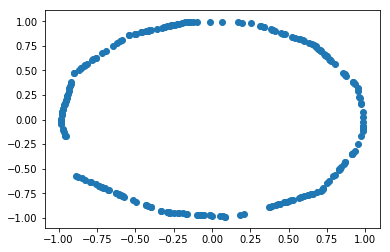

epoch = 199
loss_rec: 0.0203; loss_disc: -0.0001; loss_latent_rec: 0.0001


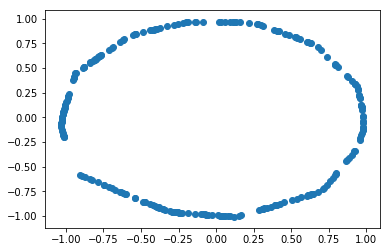

epoch = 200
loss_rec: 0.0200; loss_disc: -0.0002; loss_latent_rec: 0.0001


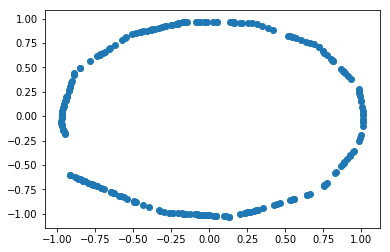

epoch = 201
loss_rec: 0.0197; loss_disc: -0.0001; loss_latent_rec: 0.0001


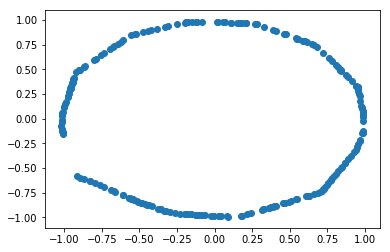

epoch = 202
loss_rec: 0.0202; loss_disc: -0.0001; loss_latent_rec: 0.0001


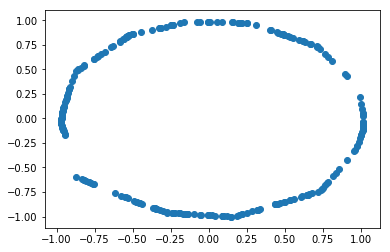

epoch = 203
loss_rec: 0.0195; loss_disc: -0.0002; loss_latent_rec: 0.0001


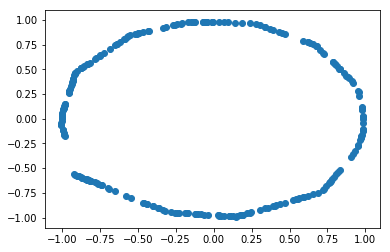

epoch = 204
loss_rec: 0.0205; loss_disc: -0.0001; loss_latent_rec: 0.0001


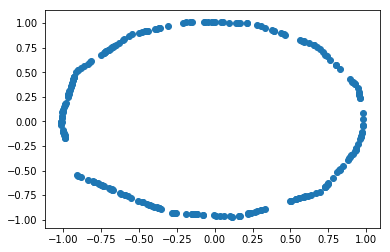

epoch = 205
loss_rec: 0.0210; loss_disc: -0.0002; loss_latent_rec: 0.0001


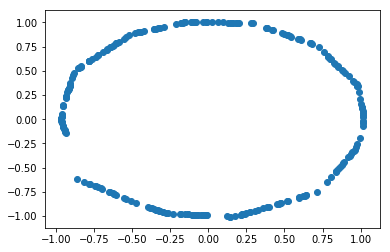

epoch = 206
loss_rec: 0.0200; loss_disc: -0.0001; loss_latent_rec: 0.0001


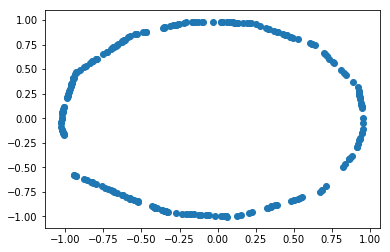

epoch = 207
loss_rec: 0.0199; loss_disc: -0.0001; loss_latent_rec: 0.0001


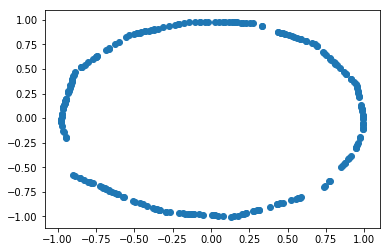

epoch = 208
loss_rec: 0.0192; loss_disc: -0.0002; loss_latent_rec: 0.0001


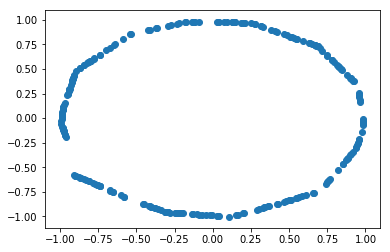

epoch = 209
loss_rec: 0.0194; loss_disc: -0.0001; loss_latent_rec: 0.0001


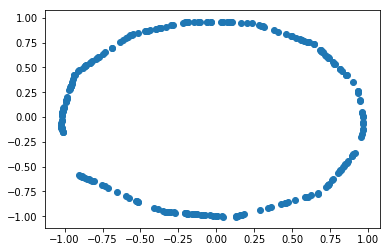

epoch = 210
loss_rec: 0.0195; loss_disc: -0.0001; loss_latent_rec: 0.0001


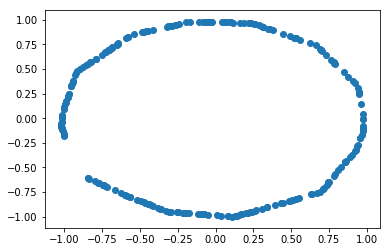

epoch = 211
loss_rec: 0.0185; loss_disc: -0.0001; loss_latent_rec: 0.0001


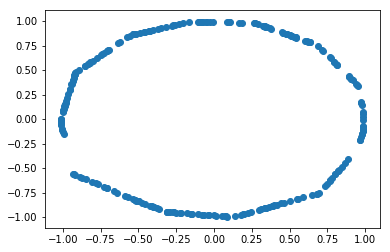

epoch = 212
loss_rec: 0.0195; loss_disc: -0.0001; loss_latent_rec: 0.0001


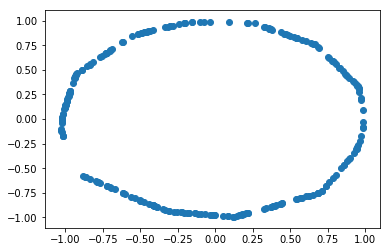

epoch = 213
loss_rec: 0.0200; loss_disc: -0.0001; loss_latent_rec: 0.0001


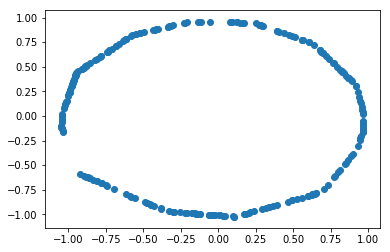

epoch = 214
loss_rec: 0.0192; loss_disc: -0.0001; loss_latent_rec: 0.0001


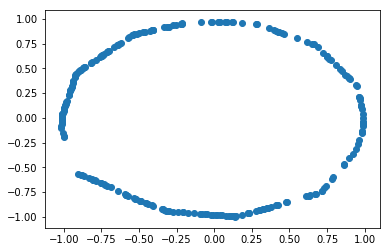

epoch = 215
loss_rec: 0.0193; loss_disc: -0.0001; loss_latent_rec: 0.0001


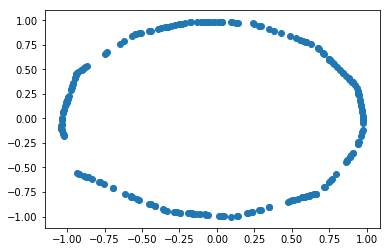

epoch = 216
loss_rec: 0.0191; loss_disc: -0.0000; loss_latent_rec: 0.0001


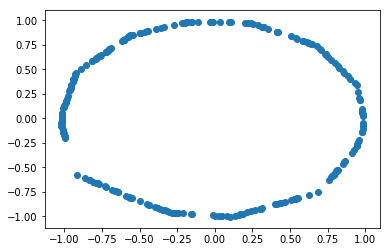

epoch = 217
loss_rec: 0.0190; loss_disc: -0.0002; loss_latent_rec: 0.0001


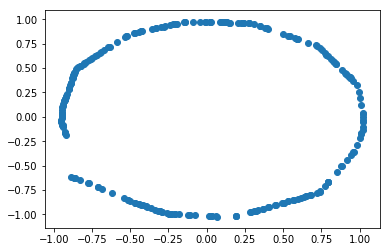

epoch = 218
loss_rec: 0.0192; loss_disc: -0.0001; loss_latent_rec: 0.0001


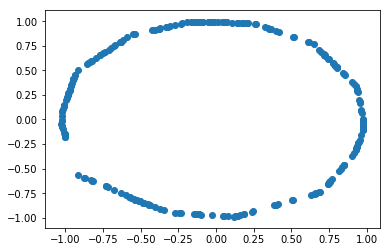

epoch = 219
loss_rec: 0.0194; loss_disc: -0.0002; loss_latent_rec: 0.0001


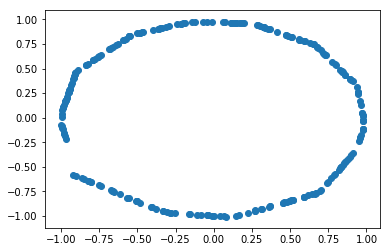

epoch = 220
loss_rec: 0.0190; loss_disc: -0.0001; loss_latent_rec: 0.0001


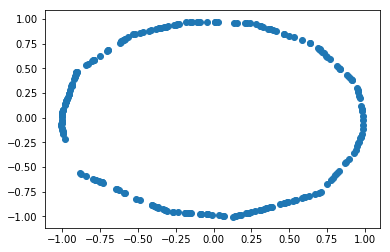

epoch = 221
loss_rec: 0.0187; loss_disc: -0.0001; loss_latent_rec: 0.0001


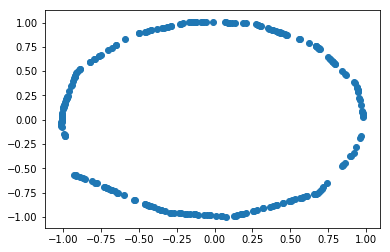

epoch = 222
loss_rec: 0.0199; loss_disc: -0.0001; loss_latent_rec: 0.0001


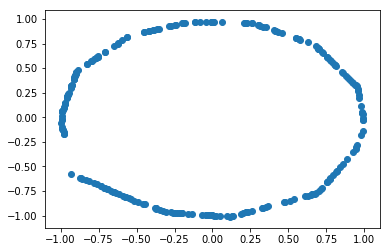

epoch = 223
loss_rec: 0.0195; loss_disc: -0.0001; loss_latent_rec: 0.0001


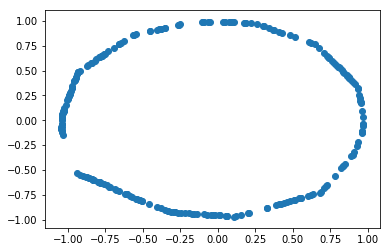

epoch = 224
loss_rec: 0.0187; loss_disc: -0.0001; loss_latent_rec: 0.0001


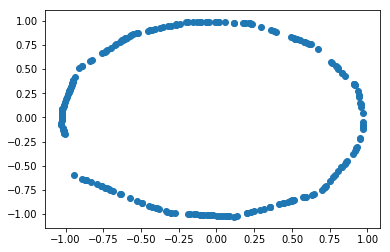

epoch = 225
loss_rec: 0.0194; loss_disc: -0.0001; loss_latent_rec: 0.0001


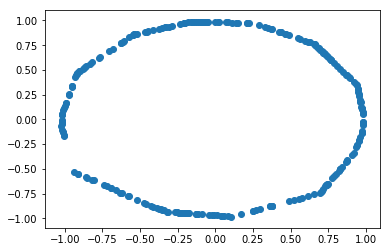

epoch = 226
loss_rec: 0.0186; loss_disc: -0.0001; loss_latent_rec: 0.0001


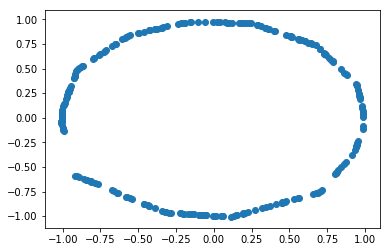

epoch = 227
loss_rec: 0.0196; loss_disc: -0.0001; loss_latent_rec: 0.0001


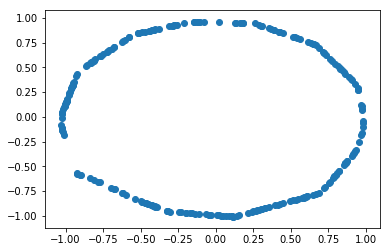

epoch = 228
loss_rec: 0.0185; loss_disc: -0.0001; loss_latent_rec: 0.0001


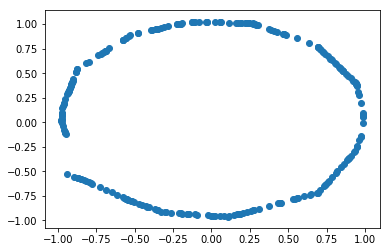

epoch = 229
loss_rec: 0.0186; loss_disc: -0.0001; loss_latent_rec: 0.0001


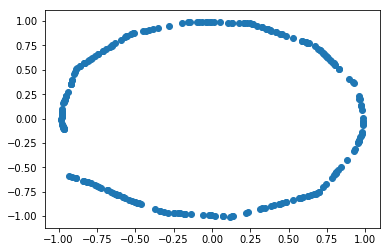

epoch = 230
loss_rec: 0.0184; loss_disc: -0.0002; loss_latent_rec: 0.0001


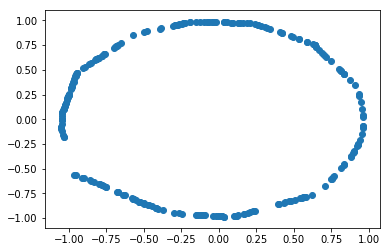

epoch = 231
loss_rec: 0.0188; loss_disc: -0.0002; loss_latent_rec: 0.0001


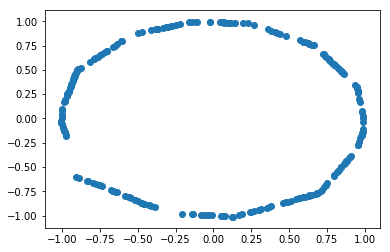

epoch = 232
loss_rec: 0.0180; loss_disc: -0.0001; loss_latent_rec: 0.0001


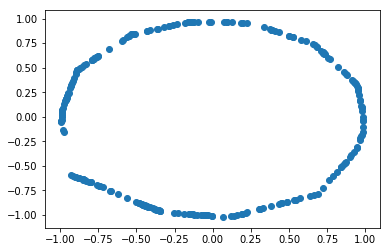

epoch = 233
loss_rec: 0.0186; loss_disc: -0.0002; loss_latent_rec: 0.0001


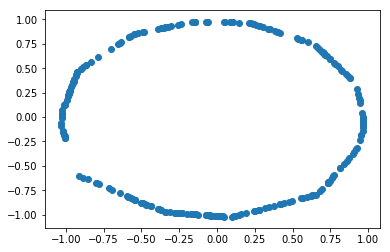

epoch = 234
loss_rec: 0.0188; loss_disc: -0.0001; loss_latent_rec: 0.0001


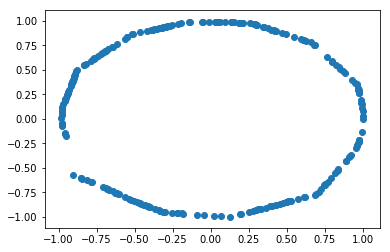

epoch = 235
loss_rec: 0.0180; loss_disc: -0.0001; loss_latent_rec: 0.0001


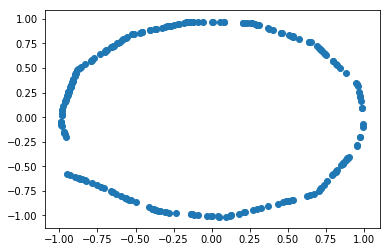

epoch = 236
loss_rec: 0.0195; loss_disc: -0.0001; loss_latent_rec: 0.0001


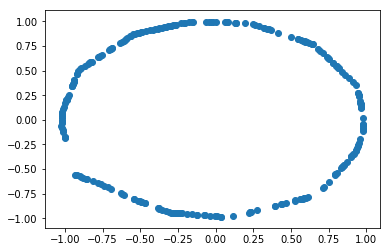

epoch = 237
loss_rec: 0.0189; loss_disc: -0.0001; loss_latent_rec: 0.0001


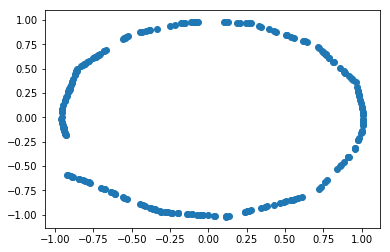

epoch = 238
loss_rec: 0.0193; loss_disc: -0.0002; loss_latent_rec: 0.0001


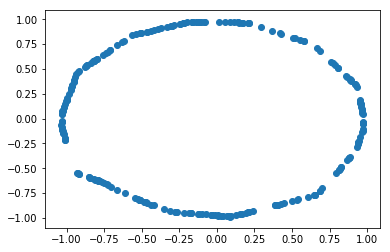

epoch = 239
loss_rec: 0.0186; loss_disc: -0.0001; loss_latent_rec: 0.0001


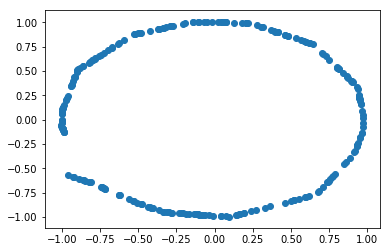

epoch = 240
loss_rec: 0.0185; loss_disc: -0.0002; loss_latent_rec: 0.0001


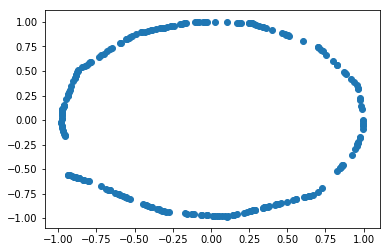

epoch = 241
loss_rec: 0.0187; loss_disc: -0.0001; loss_latent_rec: 0.0001


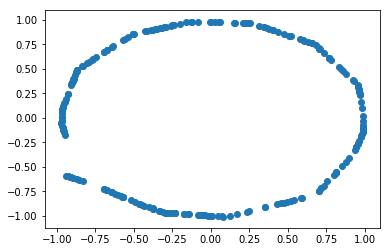

epoch = 242
loss_rec: 0.0190; loss_disc: -0.0001; loss_latent_rec: 0.0001


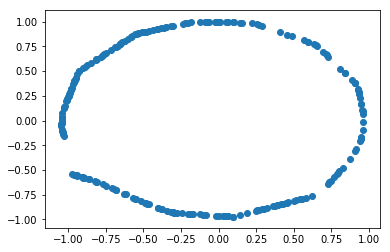

epoch = 243
loss_rec: 0.0189; loss_disc: -0.0001; loss_latent_rec: 0.0001


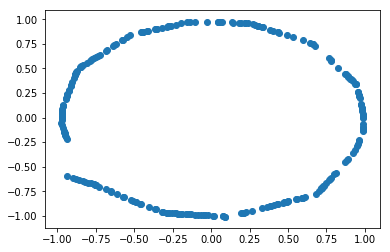

epoch = 244
loss_rec: 0.0194; loss_disc: -0.0001; loss_latent_rec: 0.0001


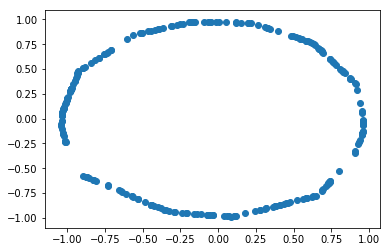

epoch = 245
loss_rec: 0.0181; loss_disc: -0.0000; loss_latent_rec: 0.0001


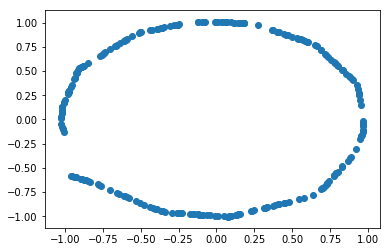

epoch = 246
loss_rec: 0.0183; loss_disc: -0.0001; loss_latent_rec: 0.0001


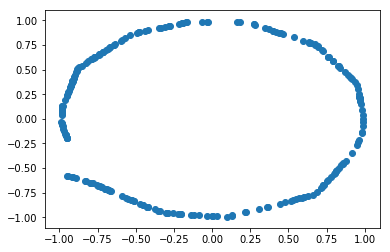

epoch = 247
loss_rec: 0.0180; loss_disc: -0.0001; loss_latent_rec: 0.0001


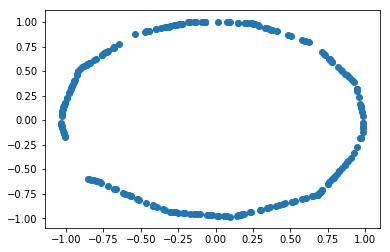

epoch = 248
loss_rec: 0.0179; loss_disc: -0.0002; loss_latent_rec: 0.0001


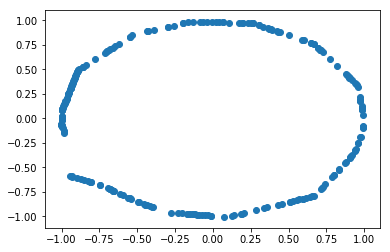

epoch = 249
loss_rec: 0.0192; loss_disc: -0.0001; loss_latent_rec: 0.0001


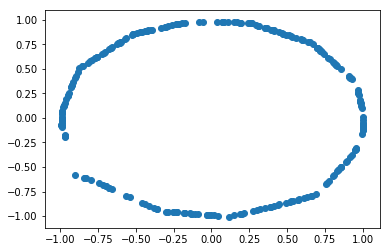

epoch = 250
loss_rec: 0.0186; loss_disc: -0.0001; loss_latent_rec: 0.0001


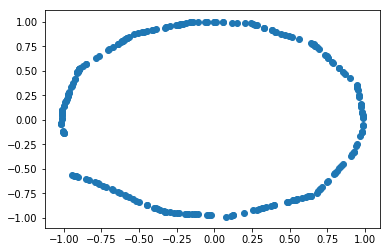

In [71]:
from itertools import chain

loss_disc_factor = 10.

wae = WAE_MMD(manifold_dim+1, manifold_dim).to(device)

optimizer_autoencoder = torch.optim.Adam(
    chain(wae._encoder.parameters(), wae._decoder.parameters()), lr=1e-3, betas=(0.9, 0.9)
)

num_epochs = 250

for epoch in range(num_epochs):
    print('epoch =', epoch+1)

    cum_loss_rec = 0
    cum_loss_disc = 0
    cum_loss_latent_rec = 0
    train_size = 0
    for k, Z in enumerate(latent_samples_batch_gen()()):
        Z = Z.to(device)
        batch_size = Z.shape[0]
        loss_rec, loss_disc, loss_latent_rec = wae.cum_batch_loss(Z)

        cum_loss_rec += loss_rec.item()
        cum_loss_disc += loss_disc.item()
        cum_loss_latent_rec += loss_latent_rec.item()
        train_size += batch_size

        optimizer_autoencoder.zero_grad()
        ((loss_rec - loss_disc_factor * loss_disc + loss_latent_rec) / batch_size).backward()
        optimizer_autoencoder.step()

    mean_loss_rec = cum_loss_rec / train_size
    mean_loss_disc = cum_loss_disc / train_size
    mean_loss_latent_rec = cum_loss_latent_rec / train_size
    print(
        'loss_rec: {:.4f}; loss_disc: {:.4f}; loss_latent_rec: {:.4f}'.format(
            mean_loss_rec, mean_loss_disc, mean_loss_latent_rec
        )
    )

    with torch.no_grad():
        Z_sample = wae.sample(batch_size)
        plt.scatter(*np.split(Z_sample.cpu().numpy(), 2, axis=1))
        plt.show()


** Visualize the manifold that WAE has fitted: **

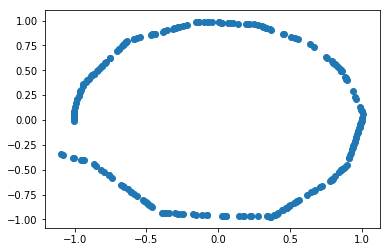

In [34]:
with torch.no_grad():
    Z_sample = wae.sample(batch_size)
    plt.scatter(*np.split(Z_sample.cpu().numpy(), 2, axis=1))

## Beta-WAE(MMD)-Gauss VAE, 1d:

In [35]:
class ManifoldLatentVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, manifold_dim, hidden_pretrained_wae: WAE_MMD, learn_hidden_wae=False):
        super(type(self), self).__init__()

        assert hidden_pretrained_wae.feature_dim == latent_dim
        assert hidden_pretrained_wae.latent_dim == manifold_dim
        
        self.manifold_dim = manifold_dim
        self.latent_dim = latent_dim
        
        self.encoder = EncoderFC(input_dim, manifold_dim)
        self.decoder = DecoderFC(latent_dim, input_dim)
        
        self.hidden_wae = hidden_pretrained_wae
        self.learn_hidden_wae = learn_hidden_wae
        
    def model(self, X):
        if self.learn_hidden_wae:
            pyro.module('hidden_decoder', self.hidden_wae._decoder)
        pyro.module('decoder', self.decoder)
        with pyro.iarange('data', X.shape[0]):
            Z_base_1 = X.new_ones((X.shape[0], self.manifold_dim))
            Z_base_2 = X.new_ones((X.shape[0], self.manifold_dim))
            
            base_dist = dist.Beta(Z_base_1, Z_base_2).independent(1)
            Z_hid = pyro.sample('latent_hid', base_dist)
            Z = self.hidden_wae._decoder(Z_hid)[0]
            
            X_obs_mean, X_obs_std = self.decoder(Z)
            pyro.sample(
                'observation', dist.Normal(X_obs_mean, X_obs_std).independent(1), obs=X
            )
        
    def guide(self, X):
        pyro.module('encoder', self.encoder)
        with pyro.iarange('data', X.shape[0]):
            Z_base_1, Z_base_2 = self.encoder(X)
            
            base_dist = dist.Beta(Z_base_1, Z_base_2).independent(1)
            Z_hid = pyro.sample('latent_hid', base_dist)
            
    def get_loglikelihood_and_kl(self, trace_elbo, X):
        loglikelihood, kl = 0., 0.
        # grab a trace from the generator
        for model_trace, guide_trace in trace_elbo._get_traces(self.model, self.guide, X):
            loglikelihood = loglikelihood + model_trace.nodes['observation']['log_prob_sum']
            kl = kl + guide_trace.nodes['latent_hid']['log_prob_sum'] - model_trace.nodes['latent_hid']['log_prob_sum']

        loglikelihood = loglikelihood / trace_elbo.num_particles
        kl = kl / trace_elbo.num_particles

        if pyro.util.torch_isnan(loglikelihood):
            warnings.warn('Encountered NAN loglikelihood')
        if pyro.util.torch_isnan(kl):
            warnings.warn('Encountered NAN KL')
        return loglikelihood, kl    

### Training:

In [72]:
model_name = 'beta-wae_mmd-gauss_vae_1d'

losses[model_name] = []
loglikelihoods[model_name] = []

for run in range(num_runs):
    print('run', run+1)

    losses[model_name].append([])

    np.random.seed(run)
    pyro.set_rng_seed(run)

    pyro.clear_param_store()

    vae = ManifoldLatentVAE(
        input_dim, manifold_dim+1, manifold_dim, wae, learn_hidden_wae=False
    ).to(device)

    optimizer = optim.ClippedAdam({'lr': 3e-4, 'betas': (0.9, 0.999)})

    trace_elbo = pyro.infer.Trace_ELBO(num_particles=1)
    svi = pyro.infer.SVI(vae.model, vae.guide, optimizer, loss=pyro.infer.Trace_ELBO())

    num_epochs = 200

    for epoch in range(num_epochs):
        print('epoch =', epoch+1)

        cum_train_loss = 0
        train_size = 0
        for X in toy_samples_batch_gen()():
            X = X[0].to(device)
            cum_train_loss += svi.step(X)
            train_size += X.shape[0]
        mean_train_loss = cum_train_loss / train_size
        print('train_loss: {:.4f}'.format(mean_train_loss))

        losses[model_name][run].append(mean_train_loss)

    if track_loglikelihoods:
        iwelbo = RenyiELBO(alpha=0, num_particles=num_iwelbo_samples)

        cum_train_loglikelihood = 0
        train_size = 0
        for X in toy_samples_batch_gen()():
            X = X[0].to(device)
            cum_train_loglikelihood -= iwelbo.loss(vae.model, vae.guide, X)
            train_size += X.shape[0]
        mean_train_loglikelihood = cum_train_loglikelihood / train_size
        print('train_loglikelihood: {:.4f}'.format(mean_train_loglikelihood))

        loglikelihoods[model_name].append(mean_train_loglikelihood)
    
    torch.save(vae.state_dict(), '{}_run={}.pt'.format(model_name, run+1))
    print()


run 1
epoch = 1
train_loss: -72.9919
epoch = 2
train_loss: -145.2352
epoch = 3
train_loss: -153.0403
epoch = 4
train_loss: -156.3627
epoch = 5
train_loss: -161.0937
epoch = 6
train_loss: -165.0313
epoch = 7
train_loss: -168.3002
epoch = 8
train_loss: -173.8265
epoch = 9
train_loss: -179.2733
epoch = 10
train_loss: -182.8883
epoch = 11
train_loss: -185.7815
epoch = 12
train_loss: -187.2615
epoch = 13
train_loss: -189.1842
epoch = 14
train_loss: -189.9438
epoch = 15
train_loss: -192.0582
epoch = 16
train_loss: -193.5204
epoch = 17
train_loss: -194.8435
epoch = 18
train_loss: -196.4826
epoch = 19
train_loss: -198.7501
epoch = 20
train_loss: -199.5813
epoch = 21
train_loss: -200.6680
epoch = 22
train_loss: -200.7179
epoch = 23
train_loss: -201.7447
epoch = 24
train_loss: -202.1578
epoch = 25
train_loss: -202.2054
epoch = 26
train_loss: -203.0922
epoch = 27
train_loss: -203.6284
epoch = 28
train_loss: -204.3136
epoch = 29
train_loss: -204.2302
epoch = 30
train_loss: -205.4365
epoch = 31
tra

train_loss: -172.9069
epoch = 48
train_loss: -173.2557
epoch = 49
train_loss: -173.2014
epoch = 50
train_loss: -173.3721
epoch = 51
train_loss: -173.7452
epoch = 52
train_loss: -173.6362
epoch = 53
train_loss: -174.0594
epoch = 54
train_loss: -173.8979
epoch = 55
train_loss: -173.4085
epoch = 56
train_loss: -173.9949
epoch = 57
train_loss: -174.0678
epoch = 58
train_loss: -174.6559
epoch = 59
train_loss: -174.1408
epoch = 60
train_loss: -174.6690
epoch = 61
train_loss: -174.7956
epoch = 62
train_loss: -174.9596
epoch = 63
train_loss: -174.8188
epoch = 64
train_loss: -175.0646
epoch = 65
train_loss: -175.2636
epoch = 66
train_loss: -175.2941
epoch = 67
train_loss: -175.5552
epoch = 68
train_loss: -175.7053
epoch = 69
train_loss: -175.9554
epoch = 70
train_loss: -176.0653
epoch = 71
train_loss: -175.9751
epoch = 72
train_loss: -176.0934
epoch = 73
train_loss: -176.2855
epoch = 74
train_loss: -176.7405
epoch = 75
train_loss: -176.7117
epoch = 76
train_loss: -177.1129
epoch = 77
train_loss

train_loss: -179.2629
epoch = 94
train_loss: -179.5035
epoch = 95
train_loss: -180.3157
epoch = 96
train_loss: -180.0629
epoch = 97
train_loss: -181.0912
epoch = 98
train_loss: -180.6402
epoch = 99
train_loss: -180.5495
epoch = 100
train_loss: -181.0725
epoch = 101
train_loss: -181.7295
epoch = 102
train_loss: -180.3143
epoch = 103
train_loss: -181.7770
epoch = 104
train_loss: -181.9853
epoch = 105
train_loss: -181.6575
epoch = 106
train_loss: -182.0001
epoch = 107
train_loss: -183.0590
epoch = 108
train_loss: -181.8953
epoch = 109
train_loss: -182.5957
epoch = 110
train_loss: -183.1600
epoch = 111
train_loss: -184.3216
epoch = 112
train_loss: -183.8805
epoch = 113
train_loss: -185.3727
epoch = 114
train_loss: -183.9646
epoch = 115
train_loss: -184.6838
epoch = 116
train_loss: -184.5993
epoch = 117
train_loss: -185.8631
epoch = 118
train_loss: -186.7210
epoch = 119
train_loss: -187.2706
epoch = 120
train_loss: -187.2502
epoch = 121
train_loss: -188.0148
epoch = 122
train_loss: -188.826

train_loss: -234.8400
epoch = 139
train_loss: -234.9851
epoch = 140
train_loss: -232.9435
epoch = 141
train_loss: -230.7262
epoch = 142
train_loss: -234.2313
epoch = 143
train_loss: -234.4992
epoch = 144
train_loss: -232.7944
epoch = 145
train_loss: -234.5163
epoch = 146
train_loss: -234.7883
epoch = 147
train_loss: -235.6320
epoch = 148
train_loss: -232.4404
epoch = 149
train_loss: -231.1982
epoch = 150
train_loss: -236.1749
epoch = 151
train_loss: -235.0221
epoch = 152
train_loss: -236.7031
epoch = 153
train_loss: -236.3986
epoch = 154
train_loss: -236.8133
epoch = 155
train_loss: -236.2063
epoch = 156
train_loss: -235.5266
epoch = 157
train_loss: -235.3593
epoch = 158
train_loss: -236.3052
epoch = 159
train_loss: -235.9460
epoch = 160
train_loss: -236.1331
epoch = 161
train_loss: -237.3766
epoch = 162
train_loss: -236.1588
epoch = 163
train_loss: -236.4195
epoch = 164
train_loss: -234.8492
epoch = 165
train_loss: -234.4565
epoch = 166
train_loss: -235.1898
epoch = 167
train_loss: -2

train_loss: -195.3935
epoch = 183
train_loss: -195.2279
epoch = 184
train_loss: -195.8987
epoch = 185
train_loss: -195.6951
epoch = 186
train_loss: -196.1614
epoch = 187
train_loss: -196.7558
epoch = 188
train_loss: -196.2808
epoch = 189
train_loss: -197.4102
epoch = 190
train_loss: -196.7199
epoch = 191
train_loss: -196.9533
epoch = 192
train_loss: -197.6185
epoch = 193
train_loss: -197.7059
epoch = 194
train_loss: -197.6247
epoch = 195
train_loss: -197.9376
epoch = 196
train_loss: -198.1478
epoch = 197
train_loss: -198.2700
epoch = 198
train_loss: -198.3848
epoch = 199
train_loss: -198.7580
epoch = 200
train_loss: -199.0325

run 6
epoch = 1
train_loss: -79.5285
epoch = 2
train_loss: -147.8090
epoch = 3
train_loss: -153.6118
epoch = 4
train_loss: -155.8033
epoch = 5
train_loss: -156.8864
epoch = 6
train_loss: -158.5198
epoch = 7
train_loss: -159.4483
epoch = 8
train_loss: -160.5441
epoch = 9
train_loss: -161.3965
epoch = 10
train_loss: -161.7964
epoch = 11
train_loss: -162.7128
epoch 

train_loss: -167.9045
epoch = 28
train_loss: -168.2481
epoch = 29
train_loss: -168.4806
epoch = 30
train_loss: -168.6780
epoch = 31
train_loss: -169.1854
epoch = 32
train_loss: -168.9876
epoch = 33
train_loss: -169.5734
epoch = 34
train_loss: -169.7239
epoch = 35
train_loss: -170.2632
epoch = 36
train_loss: -170.8760
epoch = 37
train_loss: -171.5646
epoch = 38
train_loss: -171.2893
epoch = 39
train_loss: -171.7381
epoch = 40
train_loss: -172.1169
epoch = 41
train_loss: -171.8782
epoch = 42
train_loss: -172.9647
epoch = 43
train_loss: -172.6399
epoch = 44
train_loss: -172.9306
epoch = 45
train_loss: -172.8627
epoch = 46
train_loss: -173.8177
epoch = 47
train_loss: -174.7233
epoch = 48
train_loss: -173.7770
epoch = 49
train_loss: -173.5309
epoch = 50
train_loss: -174.6700
epoch = 51
train_loss: -174.9264
epoch = 52
train_loss: -175.3901
epoch = 53
train_loss: -174.9417
epoch = 54
train_loss: -175.7404
epoch = 55
train_loss: -175.3492
epoch = 56
train_loss: -175.6949
epoch = 57
train_loss

train_loss: -166.7031
epoch = 74
train_loss: -166.7013
epoch = 75
train_loss: -166.6931
epoch = 76
train_loss: -166.7234
epoch = 77
train_loss: -166.7654
epoch = 78
train_loss: -167.0301
epoch = 79
train_loss: -166.7871
epoch = 80
train_loss: -166.7251
epoch = 81
train_loss: -166.7712
epoch = 82
train_loss: -166.8650
epoch = 83
train_loss: -167.0839
epoch = 84
train_loss: -167.0186
epoch = 85
train_loss: -166.9027
epoch = 86
train_loss: -166.6531
epoch = 87
train_loss: -167.0026
epoch = 88
train_loss: -166.0630
epoch = 89
train_loss: -166.7488
epoch = 90
train_loss: -167.1092
epoch = 91
train_loss: -167.3242
epoch = 92
train_loss: -166.9168
epoch = 93
train_loss: -167.4291
epoch = 94
train_loss: -167.0592
epoch = 95
train_loss: -167.3954
epoch = 96
train_loss: -166.9937
epoch = 97
train_loss: -167.2564
epoch = 98
train_loss: -167.3640
epoch = 99
train_loss: -167.4886
epoch = 100
train_loss: -167.7864
epoch = 101
train_loss: -167.2477
epoch = 102
train_loss: -167.4197
epoch = 103
train_

train_loss: -166.7538
epoch = 119
train_loss: -166.7464
epoch = 120
train_loss: -166.7728
epoch = 121
train_loss: -166.7468
epoch = 122
train_loss: -166.6433
epoch = 123
train_loss: -166.6331
epoch = 124
train_loss: -166.4688
epoch = 125
train_loss: -166.6931
epoch = 126
train_loss: -166.5828
epoch = 127
train_loss: -166.7428
epoch = 128
train_loss: -166.7536
epoch = 129
train_loss: -166.7825
epoch = 130
train_loss: -166.8336
epoch = 131
train_loss: -166.7706
epoch = 132
train_loss: -166.9450
epoch = 133
train_loss: -166.8295
epoch = 134
train_loss: -166.5617
epoch = 135
train_loss: -166.9411
epoch = 136
train_loss: -166.5924
epoch = 137
train_loss: -166.4912
epoch = 138
train_loss: -166.9323
epoch = 139
train_loss: -166.7358
epoch = 140
train_loss: -166.5982
epoch = 141
train_loss: -166.5707
epoch = 142
train_loss: -166.4565
epoch = 143
train_loss: -166.6385
epoch = 144
train_loss: -166.7969
epoch = 145
train_loss: -166.6571
epoch = 146
train_loss: -166.6330
epoch = 147
train_loss: -1

train_loss: -200.2548
epoch = 163
train_loss: -200.6534
epoch = 164
train_loss: -200.5667
epoch = 165
train_loss: -201.0501
epoch = 166
train_loss: -201.3886
epoch = 167
train_loss: -201.1045
epoch = 168
train_loss: -201.5748
epoch = 169
train_loss: -201.0846
epoch = 170
train_loss: -201.4909
epoch = 171
train_loss: -201.5347
epoch = 172
train_loss: -200.9353
epoch = 173
train_loss: -200.6963
epoch = 174
train_loss: -199.5239
epoch = 175
train_loss: -199.1201
epoch = 176
train_loss: -200.5551
epoch = 177
train_loss: -204.1416
epoch = 178
train_loss: -204.5298
epoch = 179
train_loss: -205.5003
epoch = 180
train_loss: -197.7905
epoch = 181
train_loss: -196.5230
epoch = 182
train_loss: -193.0107
epoch = 183
train_loss: -192.2231
epoch = 184
train_loss: -191.8092
epoch = 185
train_loss: -195.3283
epoch = 186
train_loss: -198.9302
epoch = 187
train_loss: -199.5090
epoch = 188
train_loss: -199.5433
epoch = 189
train_loss: -200.8076
epoch = 190
train_loss: -200.9576
epoch = 191
train_loss: -2

### Results:

In [73]:
model_names.append(model_name)

Text(0.5,0,'epoch')

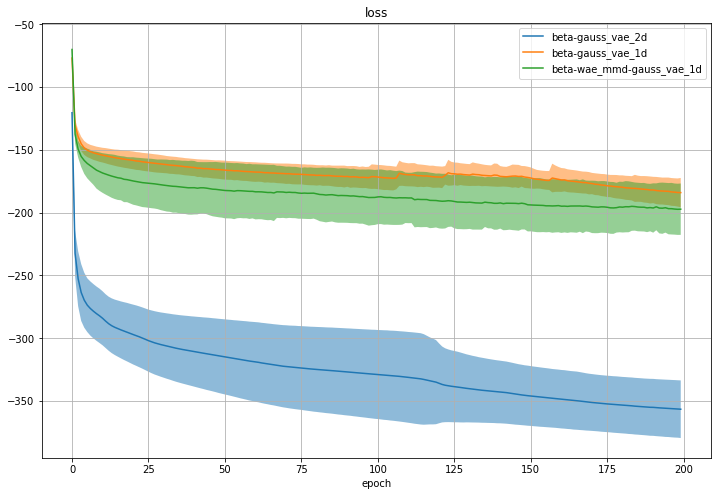

In [74]:
plt.figure(figsize=(12, 8))

for model_name in model_names:
    mean = np.mean(losses[model_name], axis=0)
    std = np.std(losses[model_name], axis=0)
    plt.plot(mean)
    plt.fill_between(
        np.arange(num_epochs), mean - std, mean + std, alpha=0.5
    )
plt.legend(model_names)
plt.grid(True)
plt.title('loss')
plt.xlabel('epoch')

In [75]:
for model_name in model_names:
    print('{}:'.format(model_name))
    mean = np.mean(losses[model_name], axis=0)[-1]
    std = np.std(losses[model_name], axis=0)[-1]
    print('test elbo: {:.4f}+-{:.4f}'.format(-mean, std))
    if track_loglikelihoods:
        mean = np.mean(loglikelihoods[model_name])
        std = np.std(loglikelihoods[model_name])
        print('test loglikelihood: {:.4f}+-{:.4f}'.format(mean, std))

beta-gauss_vae_2d:
test elbo: 356.5336+-22.9595
beta-gauss_vae_1d:
test elbo: 183.9839+-11.6638
beta-wae_mmd-gauss_vae_1d:
test elbo: 197.1885+-20.4559


** Visualize data embedded into latent space: **

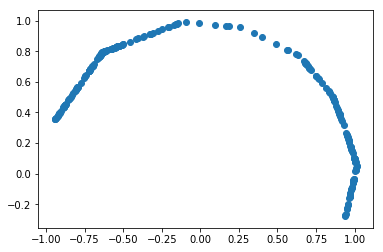

In [76]:
with torch.no_grad():
    X, components = next(iter(toy_samples_batch_gen()()))
    X = X.to(device)

    Z_hid_1, Z_hid_2 = vae.encoder(X)
    Z_hid = dist.Beta(Z_hid_1, Z_hid_2).sample()
    #Z_hid = Z_mean_hid

    Z = vae.hidden_wae.decode(Z_hid)

    for k in range(toy_samples_batch_gen.num_components):
        plt.scatter(*np.split(Z.cpu().numpy()[components == k], 2, axis=1))

## Beta-WAE(MMD)-Action-Gauss VAE, 1d:

** Our latent manifold $\mathcal{M}$ is a 1-dim sphere, for which the symmetry group is a group of rotations of a plane SO(2). Hence our group action is just a rotation in R^2: **

In [41]:
def rotate(X, angle):
    assert X.shape[1] == 2
    assert angle.shape[1] == 1
    angle = angle.view(-1)
    return torch.stack(
        (
            X[:, 0] * torch.cos(angle) - X[:, 1] * torch.sin(angle),
            X[:, 0] * torch.sin(angle) + X[:, 1] * torch.cos(angle)
        ),
        dim=1
    )

In [42]:
class ManifoldLatentActionVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, manifold_dim, hidden_pretrained_wae: WAE_MMD, learn_hidden_wae=False):
        super(type(self), self).__init__()

        assert hidden_pretrained_wae.feature_dim == latent_dim
        assert hidden_pretrained_wae.latent_dim == manifold_dim
        
        self.manifold_dim = manifold_dim
        self.latent_dim = latent_dim
        
        self.encoder = EncoderFC(input_dim, manifold_dim)
        self.decoder = DecoderFC(latent_dim, input_dim)
        
        self.action_encoder = EncoderFC(input_dim, manifold_dim)
        
        self.hidden_wae = hidden_pretrained_wae
        self.learn_hidden_wae = learn_hidden_wae
        
    def model(self, X):
        if self.learn_hidden_wae:
            pyro.module('hidden_decoder', self.hidden_wae._decoder)
        pyro.module('decoder', self.decoder)
        pyro.module('action_encoder', self.action_encoder)
        with pyro.iarange('data', X.shape[0]):
            Z_base_1 = X.new_ones((X.shape[0], self.manifold_dim))
            Z_base_2 = X.new_ones((X.shape[0], self.manifold_dim))
            
            base_dist = dist.Beta(Z_base_1, Z_base_2).independent(1)
            Z_hid = pyro.sample('latent_hid', base_dist)
            Z = self.hidden_wae._decoder(Z_hid)[0]
            
            angle = self.action_encoder(X)[0]
            Z = rotate(Z, angle)
            
            X_obs_mean, X_obs_std = self.decoder(Z)
            pyro.sample(
                'observation', dist.Normal(X_obs_mean, X_obs_std).independent(1), obs=X
            )
        
    def guide(self, X):
        pyro.module('encoder', self.encoder)
        with pyro.iarange('data', X.shape[0]):
            Z_base_1, Z_base_2 = self.encoder(X)
            
            base_dist = dist.Beta(Z_base_1, Z_base_2).independent(1)
            Z_hid = pyro.sample('latent_hid', base_dist)
            
    def get_loglikelihood_and_kl(self, trace_elbo, X):
        loglikelihood, kl = 0., 0.
        # grab a trace from the generator
        for model_trace, guide_trace in trace_elbo._get_traces(self.model, self.guide, X):
            loglikelihood = loglikelihood + model_trace.nodes['observation']['log_prob_sum']
            kl = kl + guide_trace.nodes['latent_hid']['log_prob_sum'] - model_trace.nodes['latent_hid']['log_prob_sum']

        loglikelihood = loglikelihood / trace_elbo.num_particles
        kl = kl / trace_elbo.num_particles

        if pyro.util.torch_isnan(loglikelihood):
            warnings.warn('Encountered NAN loglikelihood')
        if pyro.util.torch_isnan(kl):
            warnings.warn('Encountered NAN KL')
        return loglikelihood, kl    

### Training:

In [77]:
model_name = 'beta-wae_mmd-action-gauss_vae_1d'

losses[model_name] = []
loglikelihoods[model_name] = []

for run in range(num_runs):
    print('run', run+1)

    losses[model_name].append([])

    np.random.seed(run)
    pyro.set_rng_seed(run)

    pyro.clear_param_store()

    vae = ManifoldLatentActionVAE(
        input_dim, manifold_dim+1, manifold_dim, wae, learn_hidden_wae=False
    ).to(device)

    optimizer = optim.ClippedAdam({'lr': 3e-4, 'betas': (0.9, 0.999)})

    trace_elbo = pyro.infer.Trace_ELBO(num_particles=1)
    svi = pyro.infer.SVI(vae.model, vae.guide, optimizer, loss=pyro.infer.Trace_ELBO())

    num_epochs = 200

    for epoch in range(num_epochs):
        print('epoch =', epoch+1)

        cum_train_loss = 0
        train_size = 0
        for X in toy_samples_batch_gen()():
            X = X[0].to(device)
            cum_train_loss += svi.step(X)
            train_size += X.shape[0]
        mean_train_loss = cum_train_loss / train_size
        print('train_loss: {:.4f}'.format(mean_train_loss))

        losses[model_name][run].append(mean_train_loss)

    if track_loglikelihoods:
        iwelbo = RenyiELBO(alpha=0, num_particles=num_iwelbo_samples)

        cum_train_loglikelihood = 0
        train_size = 0
        for X in toy_samples_batch_gen()():
            X = X[0].to(device)
            cum_train_loglikelihood -= iwelbo.loss(vae.model, vae.guide, X)
            train_size += X.shape[0]
        mean_train_loglikelihood = cum_train_loglikelihood / train_size
        print('train_loglikelihood: {:.4f}'.format(mean_train_loglikelihood))

        loglikelihoods[model_name].append(mean_train_loglikelihood)
    
    torch.save(vae.state_dict(), '{}_run={}.pt'.format(model_name, run+1))
    print()


run 1
epoch = 1
train_loss: -76.5050
epoch = 2
train_loss: -178.1312
epoch = 3
train_loss: -208.6113
epoch = 4
train_loss: -219.0323
epoch = 5
train_loss: -224.1099
epoch = 6
train_loss: -229.5621
epoch = 7
train_loss: -233.7211
epoch = 8
train_loss: -237.5463
epoch = 9
train_loss: -241.7543
epoch = 10
train_loss: -245.5421
epoch = 11
train_loss: -246.4020
epoch = 12
train_loss: -244.3258
epoch = 13
train_loss: -246.7323
epoch = 14
train_loss: -249.5826
epoch = 15
train_loss: -251.9282
epoch = 16
train_loss: -251.2068
epoch = 17
train_loss: -256.2372
epoch = 18
train_loss: -258.2299
epoch = 19
train_loss: -259.6950
epoch = 20
train_loss: -260.6371
epoch = 21
train_loss: -261.3226
epoch = 22
train_loss: -263.9711
epoch = 23
train_loss: -261.0951
epoch = 24
train_loss: -265.2435
epoch = 25
train_loss: -268.6294
epoch = 26
train_loss: -270.2471
epoch = 27
train_loss: -267.3876
epoch = 28
train_loss: -270.3969
epoch = 29
train_loss: -271.2196
epoch = 30
train_loss: -269.9317
epoch = 31
tra

train_loss: -178.0113
epoch = 48
train_loss: -178.0324
epoch = 49
train_loss: -177.7025
epoch = 50
train_loss: -178.1397
epoch = 51
train_loss: -178.6055
epoch = 52
train_loss: -178.3917
epoch = 53
train_loss: -178.8396
epoch = 54
train_loss: -178.2404
epoch = 55
train_loss: -178.8684
epoch = 56
train_loss: -178.8326
epoch = 57
train_loss: -179.0801
epoch = 58
train_loss: -179.5828
epoch = 59
train_loss: -179.8102
epoch = 60
train_loss: -179.5939
epoch = 61
train_loss: -179.9969
epoch = 62
train_loss: -179.8868
epoch = 63
train_loss: -179.9567
epoch = 64
train_loss: -179.8134
epoch = 65
train_loss: -179.7815
epoch = 66
train_loss: -180.3547
epoch = 67
train_loss: -180.5901
epoch = 68
train_loss: -181.0745
epoch = 69
train_loss: -180.4955
epoch = 70
train_loss: -180.7040
epoch = 71
train_loss: -180.7773
epoch = 72
train_loss: -181.6593
epoch = 73
train_loss: -180.7965
epoch = 74
train_loss: -181.5630
epoch = 75
train_loss: -181.5625
epoch = 76
train_loss: -181.3769
epoch = 77
train_loss

train_loss: -174.2688
epoch = 94
train_loss: -174.1685
epoch = 95
train_loss: -174.3935
epoch = 96
train_loss: -174.6797
epoch = 97
train_loss: -174.6060
epoch = 98
train_loss: -175.1495
epoch = 99
train_loss: -174.7697
epoch = 100
train_loss: -175.4131
epoch = 101
train_loss: -175.6589
epoch = 102
train_loss: -175.7577
epoch = 103
train_loss: -176.4642
epoch = 104
train_loss: -176.5523
epoch = 105
train_loss: -177.0572
epoch = 106
train_loss: -177.6566
epoch = 107
train_loss: -178.2822
epoch = 108
train_loss: -178.7019
epoch = 109
train_loss: -179.4463
epoch = 110
train_loss: -180.3129
epoch = 111
train_loss: -180.9710
epoch = 112
train_loss: -181.4611
epoch = 113
train_loss: -182.0694
epoch = 114
train_loss: -182.6363
epoch = 115
train_loss: -183.1285
epoch = 116
train_loss: -183.4881
epoch = 117
train_loss: -184.4762
epoch = 118
train_loss: -184.8297
epoch = 119
train_loss: -185.1264
epoch = 120
train_loss: -185.1431
epoch = 121
train_loss: -185.9106
epoch = 122
train_loss: -186.325

train_loss: -303.3155
epoch = 139
train_loss: -303.5339
epoch = 140
train_loss: -303.8262
epoch = 141
train_loss: -303.9048
epoch = 142
train_loss: -303.9500
epoch = 143
train_loss: -304.0006
epoch = 144
train_loss: -303.9854
epoch = 145
train_loss: -303.8655
epoch = 146
train_loss: -303.5642
epoch = 147
train_loss: -303.3019
epoch = 148
train_loss: -303.3926
epoch = 149
train_loss: -303.6088
epoch = 150
train_loss: -303.4499
epoch = 151
train_loss: -303.2182
epoch = 152
train_loss: -303.2720
epoch = 153
train_loss: -302.6997
epoch = 154
train_loss: -302.6676
epoch = 155
train_loss: -303.0756
epoch = 156
train_loss: -303.3609
epoch = 157
train_loss: -302.8719
epoch = 158
train_loss: -303.2912
epoch = 159
train_loss: -303.9350
epoch = 160
train_loss: -303.9581
epoch = 161
train_loss: -303.7555
epoch = 162
train_loss: -304.1434
epoch = 163
train_loss: -303.9873
epoch = 164
train_loss: -303.9293
epoch = 165
train_loss: -304.1296
epoch = 166
train_loss: -304.1425
epoch = 167
train_loss: -3

train_loss: -272.7815
epoch = 183
train_loss: -273.9235
epoch = 184
train_loss: -274.3433
epoch = 185
train_loss: -275.5322
epoch = 186
train_loss: -275.7707
epoch = 187
train_loss: -276.8316
epoch = 188
train_loss: -276.3287
epoch = 189
train_loss: -277.9064
epoch = 190
train_loss: -279.0902
epoch = 191
train_loss: -280.6663
epoch = 192
train_loss: -280.6193
epoch = 193
train_loss: -281.5833
epoch = 194
train_loss: -282.8487
epoch = 195
train_loss: -283.4094
epoch = 196
train_loss: -284.4741
epoch = 197
train_loss: -286.0208
epoch = 198
train_loss: -284.9630
epoch = 199
train_loss: -285.5221
epoch = 200
train_loss: -286.0122

run 6
epoch = 1
train_loss: -104.9095
epoch = 2
train_loss: -225.0800
epoch = 3
train_loss: -260.3349
epoch = 4
train_loss: -272.2607
epoch = 5
train_loss: -280.8693
epoch = 6
train_loss: -287.9282
epoch = 7
train_loss: -293.6901
epoch = 8
train_loss: -297.6922
epoch = 9
train_loss: -300.5897
epoch = 10
train_loss: -302.5909
epoch = 11
train_loss: -304.9582
epoch

train_loss: -289.3924
epoch = 28
train_loss: -289.9693
epoch = 29
train_loss: -290.2763
epoch = 30
train_loss: -290.8543
epoch = 31
train_loss: -291.2546
epoch = 32
train_loss: -291.2437
epoch = 33
train_loss: -292.0785
epoch = 34
train_loss: -292.5078
epoch = 35
train_loss: -292.9808
epoch = 36
train_loss: -293.3064
epoch = 37
train_loss: -293.9540
epoch = 38
train_loss: -294.3376
epoch = 39
train_loss: -294.5516
epoch = 40
train_loss: -294.8716
epoch = 41
train_loss: -295.3874
epoch = 42
train_loss: -295.5272
epoch = 43
train_loss: -295.8391
epoch = 44
train_loss: -296.1084
epoch = 45
train_loss: -296.3289
epoch = 46
train_loss: -296.6868
epoch = 47
train_loss: -297.0029
epoch = 48
train_loss: -297.5312
epoch = 49
train_loss: -297.7048
epoch = 50
train_loss: -298.1293
epoch = 51
train_loss: -298.3830
epoch = 52
train_loss: -298.9240
epoch = 53
train_loss: -299.1239
epoch = 54
train_loss: -298.9953
epoch = 55
train_loss: -298.5377
epoch = 56
train_loss: -299.1193
epoch = 57
train_loss

train_loss: -183.8414
epoch = 74
train_loss: -184.4288
epoch = 75
train_loss: -184.5022
epoch = 76
train_loss: -185.1648
epoch = 77
train_loss: -185.3491
epoch = 78
train_loss: -185.8190
epoch = 79
train_loss: -185.5118
epoch = 80
train_loss: -185.5042
epoch = 81
train_loss: -185.0763
epoch = 82
train_loss: -185.6798
epoch = 83
train_loss: -186.1017
epoch = 84
train_loss: -186.6154
epoch = 85
train_loss: -185.9921
epoch = 86
train_loss: -186.4174
epoch = 87
train_loss: -186.4736
epoch = 88
train_loss: -187.0994
epoch = 89
train_loss: -187.4539
epoch = 90
train_loss: -187.9017
epoch = 91
train_loss: -187.9772
epoch = 92
train_loss: -187.4406
epoch = 93
train_loss: -188.4444
epoch = 94
train_loss: -187.1077
epoch = 95
train_loss: -188.6813
epoch = 96
train_loss: -187.5006
epoch = 97
train_loss: -188.6528
epoch = 98
train_loss: -188.6976
epoch = 99
train_loss: -188.6066
epoch = 100
train_loss: -188.5912
epoch = 101
train_loss: -187.6632
epoch = 102
train_loss: -189.3286
epoch = 103
train_

train_loss: -317.3451
epoch = 119
train_loss: -317.3036
epoch = 120
train_loss: -317.5228
epoch = 121
train_loss: -317.6997
epoch = 122
train_loss: -317.8974
epoch = 123
train_loss: -318.2476
epoch = 124
train_loss: -318.7233
epoch = 125
train_loss: -318.5352
epoch = 126
train_loss: -318.4252
epoch = 127
train_loss: -318.6870
epoch = 128
train_loss: -319.1356
epoch = 129
train_loss: -319.1975
epoch = 130
train_loss: -319.3116
epoch = 131
train_loss: -319.3273
epoch = 132
train_loss: -319.2479
epoch = 133
train_loss: -319.0773
epoch = 134
train_loss: -319.1465
epoch = 135
train_loss: -319.2982
epoch = 136
train_loss: -319.8527
epoch = 137
train_loss: -320.7027
epoch = 138
train_loss: -320.8265
epoch = 139
train_loss: -321.4031
epoch = 140
train_loss: -321.4623
epoch = 141
train_loss: -321.8292
epoch = 142
train_loss: -321.9552
epoch = 143
train_loss: -321.9721
epoch = 144
train_loss: -322.1639
epoch = 145
train_loss: -322.3685
epoch = 146
train_loss: -322.5679
epoch = 147
train_loss: -3

train_loss: -198.8712
epoch = 163
train_loss: -196.9435
epoch = 164
train_loss: -198.0586
epoch = 165
train_loss: -197.3936
epoch = 166
train_loss: -198.2353
epoch = 167
train_loss: -197.2349
epoch = 168
train_loss: -192.0678
epoch = 169
train_loss: -195.1167
epoch = 170
train_loss: -195.8362
epoch = 171
train_loss: -196.2022
epoch = 172
train_loss: -196.3028
epoch = 173
train_loss: -193.4935
epoch = 174
train_loss: -194.6019
epoch = 175
train_loss: -194.4276
epoch = 176
train_loss: -193.1968
epoch = 177
train_loss: -192.8142
epoch = 178
train_loss: -193.7197
epoch = 179
train_loss: -190.5647
epoch = 180
train_loss: -191.3577
epoch = 181
train_loss: -191.2665
epoch = 182
train_loss: -192.5117
epoch = 183
train_loss: -193.8261
epoch = 184
train_loss: -193.6498
epoch = 185
train_loss: -192.5677
epoch = 186
train_loss: -192.7988
epoch = 187
train_loss: -191.6165
epoch = 188
train_loss: -193.9695
epoch = 189
train_loss: -194.3672
epoch = 190
train_loss: -193.8322
epoch = 191
train_loss: -1

### Results:

In [78]:
model_names.append(model_name)

Text(0.5,0,'epoch')

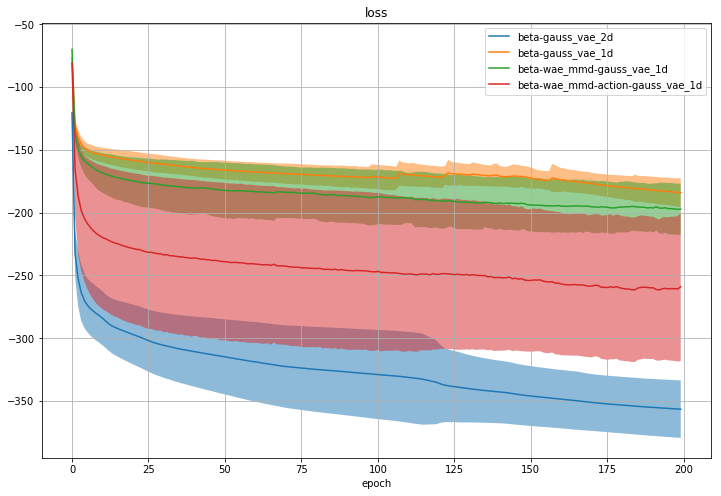

In [79]:
plt.figure(figsize=(12, 8))

for model_name in model_names:
    mean = np.mean(losses[model_name], axis=0)
    std = np.std(losses[model_name], axis=0)
    plt.plot(mean)
    plt.fill_between(
        np.arange(num_epochs), mean - std, mean + std, alpha=0.5
    )
plt.legend(model_names)
plt.grid(True)
plt.title('loss')
plt.xlabel('epoch')

In [80]:
for model_name in model_names:
    print('{}:'.format(model_name))
    mean = np.mean(losses[model_name], axis=0)[-1]
    std = np.std(losses[model_name], axis=0)[-1]
    print('test elbo: {:.4f}+-{:.4f}'.format(-mean, std))
    if track_loglikelihoods:
        mean = np.mean(loglikelihoods[model_name])
        std = np.std(loglikelihoods[model_name])
        print('test loglikelihood: {:.4f}+-{:.4f}'.format(mean, std))

beta-gauss_vae_2d:
test elbo: 356.5336+-22.9595
beta-gauss_vae_1d:
test elbo: 183.9839+-11.6638
beta-wae_mmd-gauss_vae_1d:
test elbo: 197.1885+-20.4559
beta-wae_mmd-action-gauss_vae_1d:
test elbo: 259.0303+-59.1445


** Visualize data embedded into latent space: **

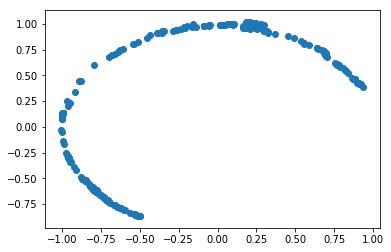

In [81]:
with torch.no_grad():
    X, components = next(iter(toy_samples_batch_gen()()))
    X = X.to(device)

    Z_hid_1, Z_hid_2 = vae.encoder(X)
    Z_hid = dist.Beta(Z_hid_1, Z_hid_2).sample()
    #Z_hid = Z_mean_hid

    Z = vae.hidden_wae.decode(Z_hid)

    angle = vae.action_encoder(X)[0]
    Z = rotate(Z, angle)
            
    for k in range(toy_samples_batch_gen.num_components):
        plt.scatter(*np.split(Z.cpu().numpy()[components == k], 2, axis=1))

## Beta-Projection-Gauss VAE, 1d:

** Here, instead of learned manifold embedding (decoder of WAE), we use fixed mapping of [0,1] segment onto 1-dim sphere: **

In [48]:
class FixedDecoder(nn.Module):
    def forward(self, angle):
        return torch.cat(
            (torch.cos(angle * 2 * 3.14), torch.sin(angle * 2 * 3.14)), dim=1
        ), None

### Training:

In [82]:
model_name = 'beta-projection-gauss_vae_1d'

losses[model_name] = []
loglikelihoods[model_name] = []

for run in range(num_runs):
    print('run', run+1)

    losses[model_name].append([])

    np.random.seed(run)
    pyro.set_rng_seed(run)

    pyro.clear_param_store()

    fixed_wae = WAE_MMD(manifold_dim+1, manifold_dim)
    fixed_wae._decoder = FixedDecoder()

    vae = ManifoldLatentVAE(
        input_dim, manifold_dim+1, manifold_dim, fixed_wae, learn_hidden_wae=False
    ).to(device)

    optimizer = optim.ClippedAdam({'lr': 3e-4, 'betas': (0.9, 0.999)})

    trace_elbo = pyro.infer.Trace_ELBO(num_particles=1)
    svi = pyro.infer.SVI(vae.model, vae.guide, optimizer, loss=pyro.infer.Trace_ELBO())

    num_epochs = 200

    for epoch in range(num_epochs):
        print('epoch =', epoch+1)

        cum_train_loss = 0
        train_size = 0
        for X in toy_samples_batch_gen()():
            X = X[0].to(device)
            cum_train_loss += svi.step(X)
            train_size += X.shape[0]
        mean_train_loss = cum_train_loss / train_size
        print('train_loss: {:.4f}'.format(mean_train_loss))

        losses[model_name][run].append(mean_train_loss)

    if track_loglikelihoods:
        iwelbo = RenyiELBO(alpha=0, num_particles=num_iwelbo_samples)

        cum_train_loglikelihood = 0
        train_size = 0
        for X in toy_samples_batch_gen()():
            X = X[0].to(device)
            cum_train_loglikelihood -= iwelbo.loss(vae.model, vae.guide, X)
            train_size += X.shape[0]
        mean_train_loglikelihood = cum_train_loglikelihood / train_size
        print('train_loglikelihood: {:.4f}'.format(mean_train_loglikelihood))

        loglikelihoods[model_name].append(mean_train_loglikelihood)
    
    torch.save(vae.state_dict(), '{}_run={}.pt'.format(model_name, run+1))
    print()


run 1
epoch = 1
train_loss: -70.0557
epoch = 2
train_loss: -128.9349
epoch = 3
train_loss: -140.3979
epoch = 4
train_loss: -149.8827
epoch = 5
train_loss: -154.0699
epoch = 6
train_loss: -156.4207
epoch = 7
train_loss: -157.2102
epoch = 8
train_loss: -158.2051
epoch = 9
train_loss: -158.9046
epoch = 10
train_loss: -159.9768
epoch = 11
train_loss: -161.0728
epoch = 12
train_loss: -162.3438
epoch = 13
train_loss: -163.5117
epoch = 14
train_loss: -164.0740
epoch = 15
train_loss: -164.3599
epoch = 16
train_loss: -164.9263
epoch = 17
train_loss: -165.3319
epoch = 18
train_loss: -165.8269
epoch = 19
train_loss: -166.0057
epoch = 20
train_loss: -166.7556
epoch = 21
train_loss: -167.0857
epoch = 22
train_loss: -167.5397
epoch = 23
train_loss: -167.3592
epoch = 24
train_loss: -167.9770
epoch = 25
train_loss: -168.3270
epoch = 26
train_loss: -168.6455
epoch = 27
train_loss: -168.6294
epoch = 28
train_loss: -169.3172
epoch = 29
train_loss: -169.3881
epoch = 30
train_loss: -169.6592
epoch = 31
tra

train_loss: -229.2692
epoch = 48
train_loss: -225.3311
epoch = 49
train_loss: -225.4423
epoch = 50
train_loss: -226.7988
epoch = 51
train_loss: -224.3320
epoch = 52
train_loss: -224.9161
epoch = 53
train_loss: -225.5116
epoch = 54
train_loss: -225.0445
epoch = 55
train_loss: -227.2867
epoch = 56
train_loss: -225.5452
epoch = 57
train_loss: -228.6316
epoch = 58
train_loss: -230.3379
epoch = 59
train_loss: -230.3791
epoch = 60
train_loss: -231.3846
epoch = 61
train_loss: -231.2563
epoch = 62
train_loss: -230.8300
epoch = 63
train_loss: -231.6955
epoch = 64
train_loss: -231.2947
epoch = 65
train_loss: -232.5970
epoch = 66
train_loss: -232.8106
epoch = 67
train_loss: -232.0536
epoch = 68
train_loss: -231.8332
epoch = 69
train_loss: -234.5035
epoch = 70
train_loss: -233.4902
epoch = 71
train_loss: -233.0765
epoch = 72
train_loss: -233.3962
epoch = 73
train_loss: -234.3084
epoch = 74
train_loss: -235.5763
epoch = 75
train_loss: -234.0988
epoch = 76
train_loss: -234.5587
epoch = 77
train_loss

train_loss: -167.2747
epoch = 94
train_loss: -167.1316
epoch = 95
train_loss: -167.1476
epoch = 96
train_loss: -167.1272
epoch = 97
train_loss: -167.1857
epoch = 98
train_loss: -167.3951
epoch = 99
train_loss: -166.5655
epoch = 100
train_loss: -167.1445
epoch = 101
train_loss: -167.6039
epoch = 102
train_loss: -166.9698
epoch = 103
train_loss: -167.2578
epoch = 104
train_loss: -167.1805
epoch = 105
train_loss: -167.2435
epoch = 106
train_loss: -167.1515
epoch = 107
train_loss: -167.3527
epoch = 108
train_loss: -167.0392
epoch = 109
train_loss: -167.1414
epoch = 110
train_loss: -167.2802
epoch = 111
train_loss: -167.2341
epoch = 112
train_loss: -167.2757
epoch = 113
train_loss: -167.3211
epoch = 114
train_loss: -167.6026
epoch = 115
train_loss: -167.3757
epoch = 116
train_loss: -166.8571
epoch = 117
train_loss: -167.3791
epoch = 118
train_loss: -167.2884
epoch = 119
train_loss: -167.0044
epoch = 120
train_loss: -167.1907
epoch = 121
train_loss: -167.0481
epoch = 122
train_loss: -167.182

train_loss: -194.4136
epoch = 139
train_loss: -192.8794
epoch = 140
train_loss: -192.3568
epoch = 141
train_loss: -194.9102
epoch = 142
train_loss: -194.7032
epoch = 143
train_loss: -195.6540
epoch = 144
train_loss: -196.2211
epoch = 145
train_loss: -196.2912
epoch = 146
train_loss: -197.1213
epoch = 147
train_loss: -196.8752
epoch = 148
train_loss: -196.5446
epoch = 149
train_loss: -197.3020
epoch = 150
train_loss: -197.7677
epoch = 151
train_loss: -197.9222
epoch = 152
train_loss: -196.6021
epoch = 153
train_loss: -198.4912
epoch = 154
train_loss: -198.5922
epoch = 155
train_loss: -197.5919
epoch = 156
train_loss: -196.4586
epoch = 157
train_loss: -196.0329
epoch = 158
train_loss: -198.6016
epoch = 159
train_loss: -198.1331
epoch = 160
train_loss: -198.1237
epoch = 161
train_loss: -197.7816
epoch = 162
train_loss: -199.2426
epoch = 163
train_loss: -199.6231
epoch = 164
train_loss: -200.2905
epoch = 165
train_loss: -199.0960
epoch = 166
train_loss: -196.7710
epoch = 167
train_loss: -1

train_loss: -224.2937
epoch = 183
train_loss: -224.7718
epoch = 184
train_loss: -224.2773
epoch = 185
train_loss: -224.2012
epoch = 186
train_loss: -224.1976
epoch = 187
train_loss: -224.5216
epoch = 188
train_loss: -225.2022
epoch = 189
train_loss: -225.4891
epoch = 190
train_loss: -225.0554
epoch = 191
train_loss: -224.2704
epoch = 192
train_loss: -224.9249
epoch = 193
train_loss: -224.8455
epoch = 194
train_loss: -225.5155
epoch = 195
train_loss: -225.8477
epoch = 196
train_loss: -225.8191
epoch = 197
train_loss: -225.6603
epoch = 198
train_loss: -225.4925
epoch = 199
train_loss: -225.8516
epoch = 200
train_loss: -226.1879

run 6
epoch = 1
train_loss: -76.8012
epoch = 2
train_loss: -148.9017
epoch = 3
train_loss: -157.8635
epoch = 4
train_loss: -164.7391
epoch = 5
train_loss: -170.4862
epoch = 6
train_loss: -174.6786
epoch = 7
train_loss: -178.1117
epoch = 8
train_loss: -180.9863
epoch = 9
train_loss: -184.1820
epoch = 10
train_loss: -186.3097
epoch = 11
train_loss: -189.0159
epoch 

train_loss: -170.3188
epoch = 28
train_loss: -171.0250
epoch = 29
train_loss: -171.3533
epoch = 30
train_loss: -171.9972
epoch = 31
train_loss: -172.1693
epoch = 32
train_loss: -172.3964
epoch = 33
train_loss: -173.1007
epoch = 34
train_loss: -173.5899
epoch = 35
train_loss: -173.8238
epoch = 36
train_loss: -174.4779
epoch = 37
train_loss: -174.9247
epoch = 38
train_loss: -175.3687
epoch = 39
train_loss: -175.9357
epoch = 40
train_loss: -176.2307
epoch = 41
train_loss: -176.7096
epoch = 42
train_loss: -176.7460
epoch = 43
train_loss: -177.2140
epoch = 44
train_loss: -177.8744
epoch = 45
train_loss: -177.8828
epoch = 46
train_loss: -178.2738
epoch = 47
train_loss: -178.9083
epoch = 48
train_loss: -178.8676
epoch = 49
train_loss: -179.1587
epoch = 50
train_loss: -179.7729
epoch = 51
train_loss: -177.7234
epoch = 52
train_loss: -180.0104
epoch = 53
train_loss: -180.5457
epoch = 54
train_loss: -180.7079
epoch = 55
train_loss: -180.9580
epoch = 56
train_loss: -181.0414
epoch = 57
train_loss

train_loss: -178.5294
epoch = 74
train_loss: -178.7983
epoch = 75
train_loss: -178.8136
epoch = 76
train_loss: -179.2708
epoch = 77
train_loss: -179.6466
epoch = 78
train_loss: -180.2498
epoch = 79
train_loss: -180.4348
epoch = 80
train_loss: -180.2179
epoch = 81
train_loss: -180.6847
epoch = 82
train_loss: -181.1207
epoch = 83
train_loss: -181.1749
epoch = 84
train_loss: -181.4027
epoch = 85
train_loss: -181.8392
epoch = 86
train_loss: -181.3205
epoch = 87
train_loss: -182.2365
epoch = 88
train_loss: -182.2930
epoch = 89
train_loss: -182.4584
epoch = 90
train_loss: -183.0428
epoch = 91
train_loss: -182.8589
epoch = 92
train_loss: -183.4536
epoch = 93
train_loss: -183.7736
epoch = 94
train_loss: -183.9132
epoch = 95
train_loss: -184.1119
epoch = 96
train_loss: -183.0757
epoch = 97
train_loss: -183.6383
epoch = 98
train_loss: -184.1120
epoch = 99
train_loss: -184.3527
epoch = 100
train_loss: -185.2695
epoch = 101
train_loss: -184.9758
epoch = 102
train_loss: -184.7852
epoch = 103
train_

train_loss: -153.0743
epoch = 119
train_loss: -153.4447
epoch = 120
train_loss: -153.2663
epoch = 121
train_loss: -153.2278
epoch = 122
train_loss: -153.4536
epoch = 123
train_loss: -153.2727
epoch = 124
train_loss: -153.3477
epoch = 125
train_loss: -153.4267
epoch = 126
train_loss: -153.1758
epoch = 127
train_loss: -153.2436
epoch = 128
train_loss: -152.9288
epoch = 129
train_loss: -153.0525
epoch = 130
train_loss: -153.1716
epoch = 131
train_loss: -153.0393
epoch = 132
train_loss: -153.1177
epoch = 133
train_loss: -153.2470
epoch = 134
train_loss: -153.0563
epoch = 135
train_loss: -152.9827
epoch = 136
train_loss: -152.6445
epoch = 137
train_loss: -152.9128
epoch = 138
train_loss: -152.8600
epoch = 139
train_loss: -152.6646
epoch = 140
train_loss: -152.7362
epoch = 141
train_loss: -152.4199
epoch = 142
train_loss: -152.5812
epoch = 143
train_loss: -152.5977
epoch = 144
train_loss: -152.7008
epoch = 145
train_loss: -152.7039
epoch = 146
train_loss: -152.3939
epoch = 147
train_loss: -1

train_loss: -165.1074
epoch = 163
train_loss: -165.0494
epoch = 164
train_loss: -164.7573
epoch = 165
train_loss: -165.2772
epoch = 166
train_loss: -165.0402
epoch = 167
train_loss: -165.4608
epoch = 168
train_loss: -165.1136
epoch = 169
train_loss: -165.1088
epoch = 170
train_loss: -164.7930
epoch = 171
train_loss: -165.0084
epoch = 172
train_loss: -164.8018
epoch = 173
train_loss: -164.8182
epoch = 174
train_loss: -164.8645
epoch = 175
train_loss: -165.2401
epoch = 176
train_loss: -164.8277
epoch = 177
train_loss: -164.7989
epoch = 178
train_loss: -164.6071
epoch = 179
train_loss: -164.7008
epoch = 180
train_loss: -164.5590
epoch = 181
train_loss: -164.8403
epoch = 182
train_loss: -164.5847
epoch = 183
train_loss: -164.5358
epoch = 184
train_loss: -164.5019
epoch = 185
train_loss: -164.2115
epoch = 186
train_loss: -164.6579
epoch = 187
train_loss: -164.4115
epoch = 188
train_loss: -164.8874
epoch = 189
train_loss: -164.6777
epoch = 190
train_loss: -164.5039
epoch = 191
train_loss: -1

### Results:

In [83]:
model_names.append(model_name)

Text(0.5,0,'epoch')

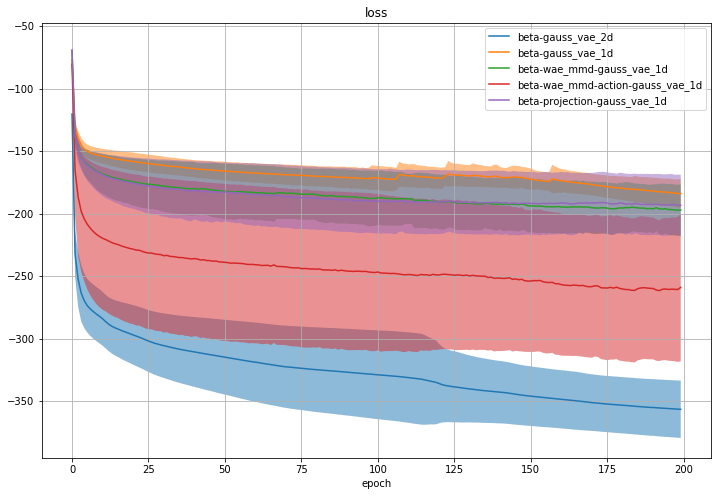

In [84]:
plt.figure(figsize=(12, 8))

for model_name in model_names:
    mean = np.mean(losses[model_name], axis=0)
    std = np.std(losses[model_name], axis=0)
    plt.plot(mean)
    plt.fill_between(
        np.arange(num_epochs), mean - std, mean + std, alpha=0.5
    )
plt.legend(model_names)
plt.grid(True)
plt.title('loss')
plt.xlabel('epoch')

In [85]:
for model_name in model_names:
    print('{}:'.format(model_name))
    mean = np.mean(losses[model_name], axis=0)[-1]
    std = np.std(losses[model_name], axis=0)[-1]
    print('test elbo: {:.4f}+-{:.4f}'.format(-mean, std))
    if track_loglikelihoods:
        mean = np.mean(loglikelihoods[model_name])
        std = np.std(loglikelihoods[model_name])
        print('test loglikelihood: {:.4f}+-{:.4f}'.format(mean, std))

beta-gauss_vae_2d:
test elbo: 356.5336+-22.9595
beta-gauss_vae_1d:
test elbo: 183.9839+-11.6638
beta-wae_mmd-gauss_vae_1d:
test elbo: 197.1885+-20.4559
beta-wae_mmd-action-gauss_vae_1d:
test elbo: 259.0303+-59.1445
beta-projection-gauss_vae_1d:
test elbo: 193.3954+-24.5655


** Visualize data embedded into latent space: **

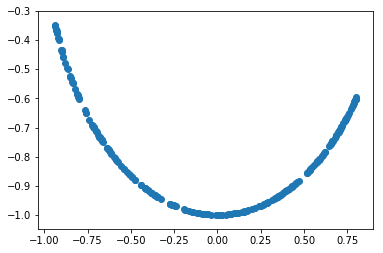

In [86]:
with torch.no_grad():
    X, components = next(iter(toy_samples_batch_gen()()))
    X = X.to(device)

    Z_hid_1, Z_hid_2 = vae.encoder(X)
    Z_hid = dist.Beta(Z_hid_1, Z_hid_2).sample()
    #Z_hid = Z_mean_hid

    Z = vae.hidden_wae.decode(Z_hid)

    for k in range(toy_samples_batch_gen.num_components):
        plt.scatter(*np.split(Z.cpu().numpy()[components == k], 2, axis=1))


In [87]:
import pickle

with open('losses_1component_noise=0.0.pkl', 'wb') as f:
    pickle.dump(losses, f)

In [55]:
with open('loglikelihoods_1component_noise=0.0.pkl', 'wb') as f:
    pickle.dump(loglikelihoods, f)